In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ComplexHeatmap))
options(bitmapType = 'cairo', device = 'png')


setwd('/psycl/g/mpsziller/lucia/SCZ_PGC/eQTL_PROJECT')
tissues_name <- read.table('Tissues_all', h=F, stringsAsFactors = F)$V1
geneInfo_file <-  '/psycl/g/mpsziller/lucia/PriLer_PROJECT_CMC/OUTPUT_SCZ-PGC_SCRIPTS_v2/train_All/200kb/resPrior_regEval_allchr.txt'
geneInfo_file <- c(geneInfo_file, sprintf('/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_SCZ-PGC/%s/200kb/PGC_GWAS_bin1e-2/resPrior_regEval_allchr.txt', tissues_name[-1]))
fold_cl <- 'clustering_res_matchUKBB_corrPCs/DLPC_CMC/'
clust_res <- get(load(sprintf('%smatchUKBB_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_minimal.RData', fold_cl)))
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
outFold <- sprintf('%sSCZ_clustering/', fold_notebook)
type_data <- 'tscore'
type_input <- 'zscaled'
type_cluster <- 'Cases'
pheno_name <- 'SCZ'
pval_corr_thr <- 0.01
color_tissues <- read.table(sprintf('%scolor_tissues.txt', fold_notebook), header = T, stringsAsFactors = F)

# load tscore and pathway results:
loci_all <- fread(sprintf('%smatchUKBB_tscore_corrPCs_zscaled_clusterCases_summary_geneLoci_allTissues.txt', fold_cl),
                      h=T, stringsAsFactors = F, data.table = F)
loci_tissues <- fread(sprintf('%smatchUKBB_tscore_corrPCs_zscaled_clusterCases_summary_geneLoci_tissueSpec.txt', fold_cl), 
                      h=T, stringsAsFactors = F, data.table = F)
pathway_feat <- get(load(sprintf('%sreduced_matchUKBB_pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold_cl)))
tscore_feat <- get(load(sprintf('%sreduced_matchUKBB_tscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold_cl)))
pathway_feat_wiki <- get(load(sprintf('%sreduced_matchUKBB_customPath_WikiPath2019HumanOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold_cl)))
pathway_feat_CMCset <- get(load(sprintf('%sreduced_matchUKBB_customPath_CMC_GeneSetsOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold_cl)))



In [3]:
print(paste('number of genes used for clustering:',length(clust_res$feat)))

[1] "number of genes used for clustering: 5682"


,dataset,gr,nloci,nloci_rep_sign,nloci_rep,nperc_loci_rep_sign
,<chr>,<chr>,<int>,<int>,<int>,<dbl>
1,scz_boco_eur,gr_1,11,8,1,0.7272727
2,scz_boco_eur,gr_2,17,9,1,0.5294118
3,scz_boco_eur,gr_3,14,8,1,0.5714286
4,scz_boco_eur,gr_4,23,18,1,0.7826087


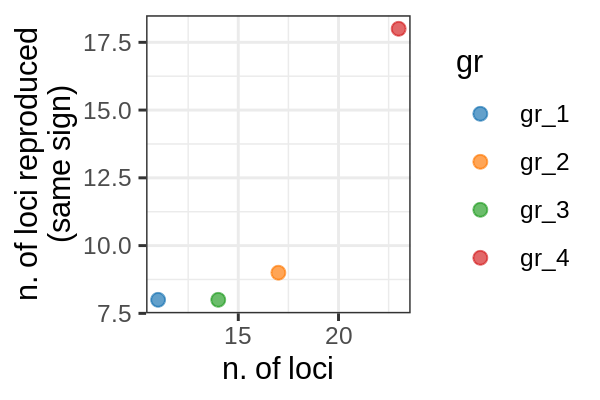

In [4]:
### make plot for reproducibility (plot loci same sign) ###
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

df_perc_loci <- read.table(sprintf('%spredict_scz_boco_eur/matchUKBB_tscore_corrPCs_zscaled_clusterCases_numberLociRep_prediction_modelPGC2.txt', fold_cl), header = T, stringsAsFactors = F, sep = '\t')
cohort_name <- 'scz_boco_eur'
gr_color <- pal_d3(palette = 'category20')(nrow(df_perc_loci))
df_perc_loci

# df_perc_loci_filt <- read.table(sprintf('%spredict_scz_boco_eur/matchUKBB_filt0.1_tscore_corrPCs_zscaled_clusterCases_numberLociRep_prediction_modelPGC2.txt', fold_cl), header = T, stringsAsFactors = F, sep = '\t')

df_perc_loci$dataset <- factor(df_perc_loci$dataset, levels = cohort_name)
df_perc_loci$gr <- factor(df_perc_loci$gr)
  
if(length(cohort_name)>1){  
    pl <- ggplot(df_perc_loci,aes(x = nloci, y = nloci_rep_sign, color = gr))+
      geom_point(alpha = 0.7, size = 2)+
      facet_wrap(.~dataset, nrow = 1)+
      theme_bw()+ 
      ylab('n. of loci reproduced\n(same sign)')+ xlab('n. of loci')+
      theme(legend.position = 'right')+
      scale_color_manual(values = gr_color)
    # scale_shape_manual(values=c(1, 19))+
    width_plot=1.5*length(cohort_name)
  }else{
    pl <- ggplot(df_perc_loci,aes(x = nloci, y = nloci_rep_sign, color = gr))+
      geom_point(alpha = 0.7, size = 2)+
      theme_bw()+
      ylab('n. of loci reproduced\n(same sign)')+ xlab('n. of loci')+
      theme(legend.position = 'right')+
      scale_color_manual(values = gr_color)
    width_plot=3
  }
  
pl
ggsave(filename = sprintf('%spredict_scz_boco_eur/matchUKBB_%s_%s_cluster%s_numberLociRepSign_Groups_prediction_model%s.pdf',
                          fold_cl, type_data, type_input, type_cluster, 'PCG2'), width = width_plot,
       height = 2, plot = pl, device = 'pdf')
  



In [5]:
clust_res$test_cov

cov_id,pval,statistic,test_type,kNN
<chr>,<dbl>,<dbl>,<chr>,<int>
C1,3.143041e-13,61.2725575,kruskal,20
C2,0.000000e+00,94.0602252,kruskal,20
C3,6.216174e-02,7.3274504,kruskal,20
C4,2.079000e-04,19.5748631,kruskal,20
C5,3.661194e-02,8.5073157,kruskal,20
C6,7.388862e-01,1.2590209,kruskal,20
C7,7.542882e-01,1.1946479,kruskal,20
C9,5.623127e-01,2.0489338,kruskal,20
C15,9.080227e-01,0.5489067,kruskal,20


In [6]:
### functions ###
create_df_genes <- function(alltissues_loci, tissue_spec_loci, gr_tot){
    
   df <- data.frame(ngenes = c(), tissue = c(), comp = c(), loci = c())
    tissues <- unique(tissue_spec_loci$tissue)
    
    for(i in 1:length(gr_tot)){
      tmp <- alltissues_loci[grepl(gr_tot[i], alltissues_loci$comp_sign),]
      df <- rbind(df, data.frame(ngenes = tmp$ngenes_unique, 
                                 tissue = rep('All', nrow(tmp)), 
                                 comp = rep(gr_tot[i], nrow(tmp)), 
                                 loci = tmp$loci_id))
    }

    for(j in 1:length(tissues)){
      for(i in 1:length(gr_tot)){
        tmp <- tissue_spec_loci[grepl(gr_tot[i], tissue_spec_loci$comp_sign) & tissue_spec_loci$tissue %in% tissues[j],]
        df <- rbind(df, data.frame(ngenes = tmp$ngenes, 
                                   tissue = rep(tissues[j], nrow(tmp)), 
                                   comp = rep(gr_tot[i], nrow(tmp)), loci = tmp$loci_id))
      }
    }

    df$comp <- factor(df$comp, levels = unname(gr_tot))
    df$tissue <- factor(df$tissue, levels = c('All', tissues))
    # newcolours <- c('grey', color_tissues$color[match(tissues, color_tissues$tissues)])
    # put loci in id based on overall comparison
    df$loci_name <- df$loci
    id_notall <- which(df$tissue !='All')
    for(i in id_notall){
      tmp <- tissue_spec_loci[tissue_spec_loci$loci_id == df$loci[i] & grepl(df$comp[i], tissue_spec_loci$comp_sign) & tissue_spec_loci$tissue == df$tissue[i] ,]
      tmp_all <- alltissues_loci[alltissues_loci$chrom == tmp$chrom,]
      tmp_all <- tmp_all[which.min(abs(tmp_all$start - tmp$start)),]
      df$loci_name[i] <- tmp_all$loci_id
    }
    df$loci_name <- factor(df$loci_name, levels =unique( alltissues_loci$loci_id))

    # same plot but n. of loci and not genes
    df_loci <- data.frame(tissue = unlist(lapply(c('All', tissues), function(x) rep(x, length(gr_tot)))), comp = rep(gr_tot, length(tissues)+1), 
                          nloci = as.vector(table(df$comp, df$tissue)))
    df_loci$comp <- factor(df_loci$comp, levels = unname(gr_tot))
    df_loci$tissue <- factor(df_loci$tissue, levels = c('All', tissues))
                                          
    df$comp <- factor(df$comp, levels = unname(gr_tot))
    df$tissue <- factor(df$tissue, levels = c('All', tissues))
    # newcolours <- c('grey', color_tissues$color[match(tissues, color_tissues$tissues)])
    # put loci in id based on overall comparison
    df$loci_name <- df$loci
    id_notall <- which(df$tissue !='All')
    for(i in id_notall){
      tmp <- tissue_spec_loci[tissue_spec_loci$loci_id == df$loci[i] & grepl(df$comp[i], tissue_spec_loci$comp_sign) & tissue_spec_loci$tissue == df$tissue[i] ,]
      tmp_all <- alltissues_loci[alltissues_loci$chrom == tmp$chrom,]
      tmp_all <- tmp_all[which.min(abs(tmp_all$start - tmp$start)),]
      df$loci_name[i] <- tmp_all$loci_id
    }
    df$loci_name <- factor(df$loci_name, levels =unique( alltissues_loci$loci_id))

    # same plot but n. of loci and not genes
    df_loci <- data.frame(tissue = unlist(lapply(c('All', tissues), function(x) rep(x, length(gr_tot)))), comp = rep(gr_tot, length(tissues)+1), 
                          nloci = as.vector(table(df$comp, df$tissue)))
    df_loci$comp <- factor(df_loci$comp, levels = unname(gr_tot))
    df_loci$tissue <- factor(df_loci$tissue, levels = c('All', tissues))
                                          
    return(list(df = df, count_loci = df_loci))
}


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


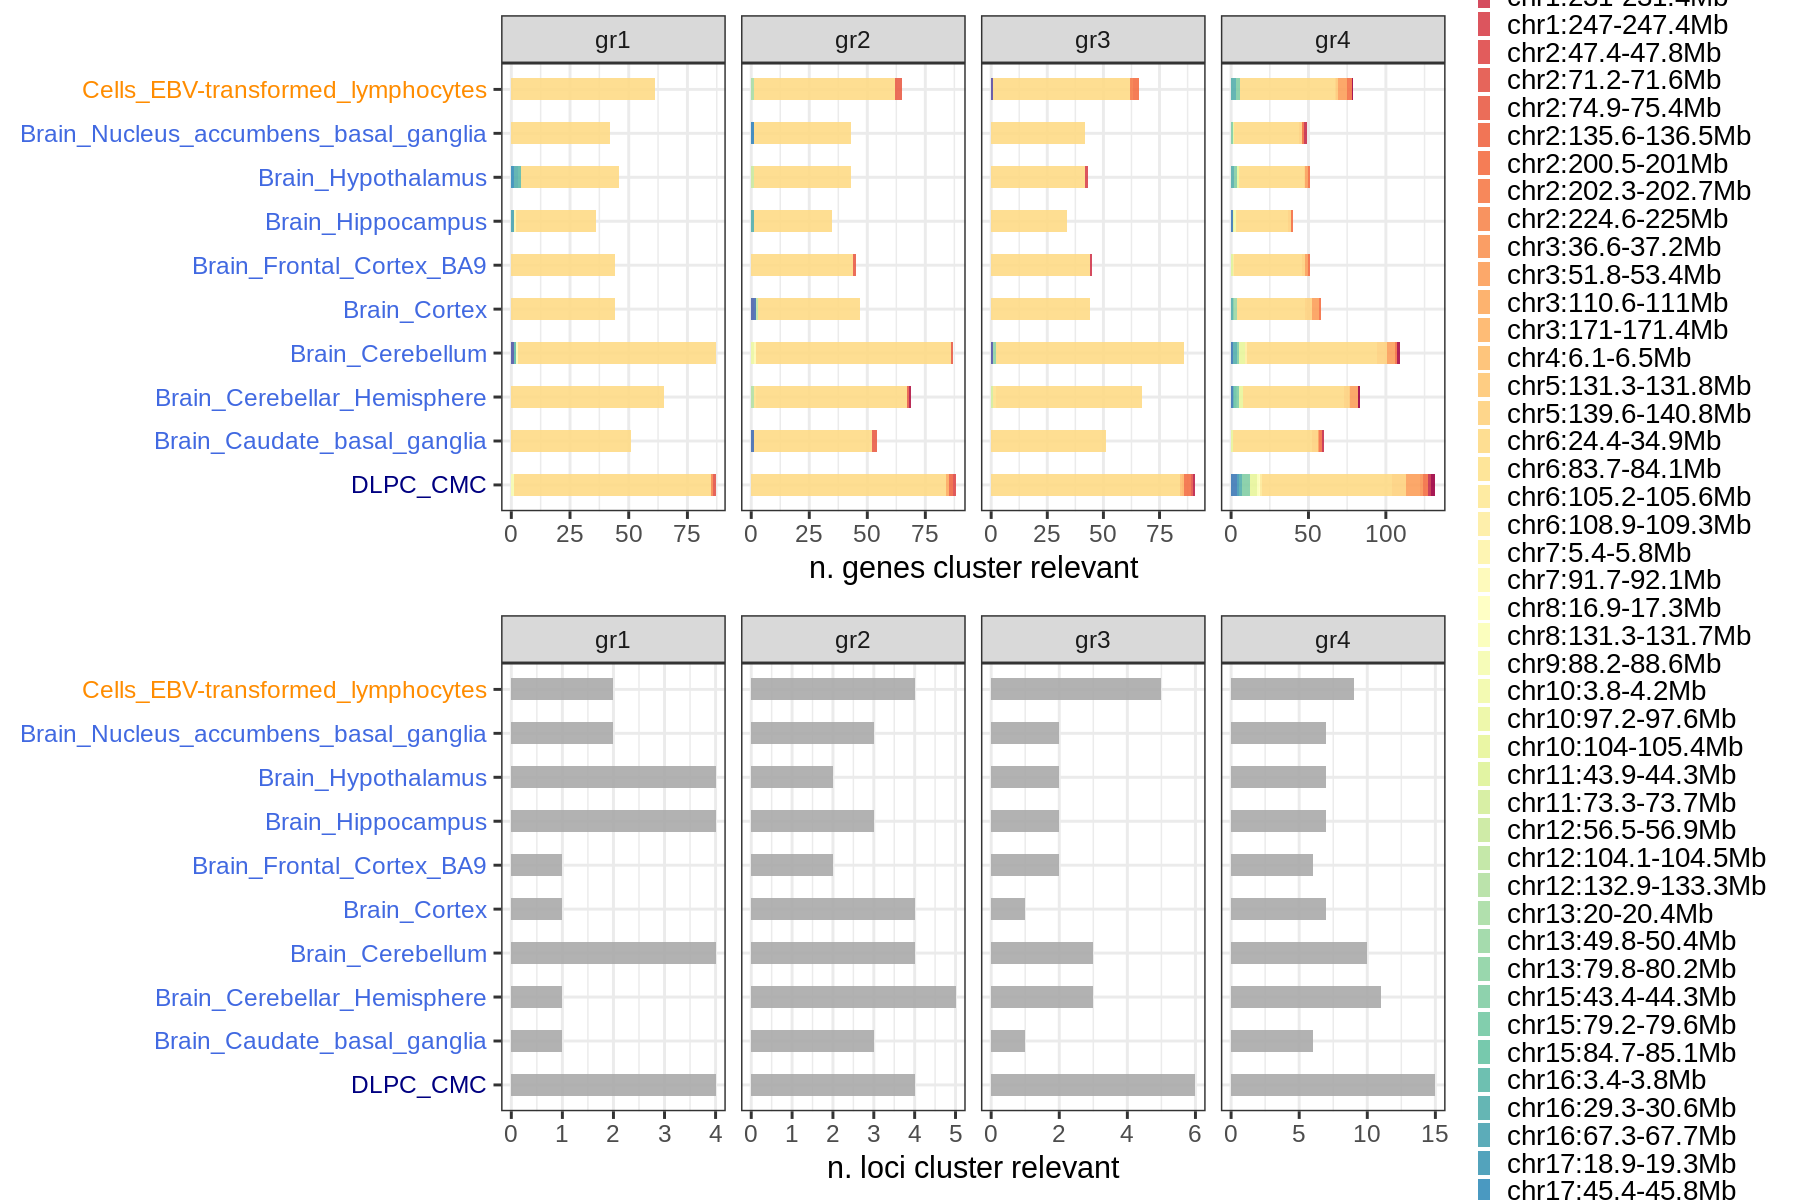

In [7]:
#### plot count (across tissues) ####
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200)

gr_tot <- paste0('gr', sort(unique(clust_res$cl_best$gr)))
out <- create_df_genes(alltissues_loci = loci_all, tissue_spec_loci = loci_tissues, gr_tot = gr_tot)
df <- out$df
df_loci <- out$count_loci
newcolours <- c('grey', color_tissues$color[match(tissues_name, color_tissues$tissues)])

coul <- colorRampPalette(brewer.pal(11, "Spectral"))(length(levels(df$loci_name)))
color_gr <- pal_d3("category10")(length(gr_tot))

pl1 <- ggplot(data = subset(df, tissue != 'All'), aes(x = tissue, y = ngenes, fill = loci_name))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity')+
  facet_wrap(.~comp, ncol = length(gr_tot), scales = 'free_x')+
  ylab('n. genes cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'right', legend.key.size = unit(0.2, "cm"), 
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.y = element_blank(), axis.text.y = element_text(colour = newcolours[-1]))+
  guides(fill=guide_legend(ncol=1))+
  scale_fill_manual(values = coul)+
  coord_flip() 

pl2 <- ggplot(data = subset(df_loci, tissue != 'All'), aes(x = tissue, y = nloci))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity', fill = 'darkgrey')+
  facet_wrap(.~comp, ncol = length(gr_tot), scales = 'free_x')+
  ylab('n. loci cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'right', legend.key.size = unit(0.5, "cm"), 
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.y = element_blank(), axis.text.y = element_text(colour = newcolours[-1]))+
  coord_flip() 

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol=1, nrow=2, 
                    align = 'v', common.legend = T,
                    legend = 'right')
tot_pl
ggsave(filename = sprintf('%scluster_ngenes_nloci_pertissues_%s_%s.pdf', outFold, type_data, type_input),
       plot = tot_pl, width = 9, height = 6, dpi = 200)



Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


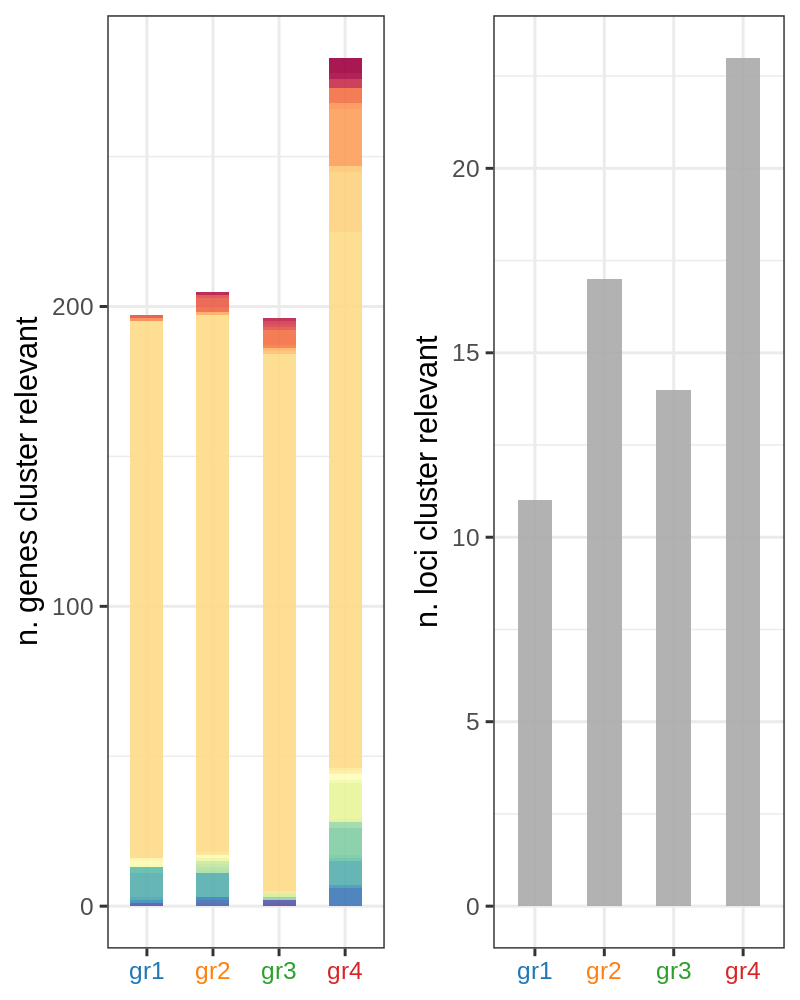

In [8]:
#### plot count (combined tissues) ####
options(repr.plot.width = 4, repr.plot.height = 5, repr.plot.res = 200)

pl1 <- ggplot(data = subset(df, tissue == 'All'), aes(x = comp, y = ngenes, fill = loci_name))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity')+
  ylab('n. genes cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'none', legend.key.size = unit(0.2, "cm"), plot.title = element_text(hjust = 0.5),
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.text.x = element_text(colour = color_gr))+
  scale_fill_manual(values = coul)+
  guides(fill=guide_legend(ncol=1))

pl2 <- ggplot(data = subset(df_loci, tissue == 'All'), aes(x = comp, y = nloci))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity', fill = 'darkgrey')+
  # facet_wrap(.~comp, ncol = length(gr_tot), scales = 'free_x')+
  ylab('n. loci cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'none', legend.key.size = unit(0.5, "cm"), 
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.text.x = element_text(colour = color_gr))+
  scale_fill_d3()

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol=2, nrow=1, align = 'h')
ggsave(filename = sprintf('%scluster_ngenes_nloci_alltissues_%s_%s.pdf', outFold, type_data, type_input), 
       plot = tot_pl, width = 4, height = 5, dpi = 200)
tot_pl


In [9]:
### function for heatmap plot (genes)
get_short_name <- function(tissue_name){
    
  tmp <- sapply(strsplit(tissue_name, split = '_')[[1]], function(x) 
        substr(x = x, start = 1, stop = 1))
  if(!tissue_name %in% c('Brain_Hippocampus','Brain_Hypothalamus',
                         'Brain_Cerebellum', 'Brain_Cerebellar_Hemisphere', 
                         'DLPC_CMC')){
    out <- paste0(tmp, collapse = '')
    out <- paste0('(', out,')')
  }else{
       if('Brain_Hippocampus' == tissue_name){out <- '(BHi)'}
      if('Brain_Hypothalamus'== tissue_name){out <- '(BHy)'}
      if('Brain_Cerebellum' == tissue_name){out <- '(BCe)'}
      if('Brain_Cerebellar_Hemisphere' == tissue_name){out <- '(BCeH)'}
      if('DLPC_CMC'  == tissue_name){out <- '(DLPC)'}
  }              
                
    return(out)
}

df_match <- data.frame(tissue = tissues_name, 
                       short = sapply(tissues_name, function(x) get_short_name(x)))

tscore_tot <- do.call(rbind, tscore_feat$test_feat) 
tscore_tot <- left_join(tscore_tot, df_match) %>%
    mutate(new_id = paste(feat, short)) 
tscore_sign <- tscore_tot %>% filter(pval_corr <= pval_corr_thr)

# combine res_pval:                                      
res_pval_tot <- do.call(rbind, tscore_feat$res_pval) 
res_pval_tot <- left_join(res_pval_tot, df_match) %>%
    mutate(new_id = paste(external_gene_name, short)) 
                                      
length(unique(tscore_sign$new_id))
length(unique(tscore_sign$feat))
nrow(loci_tissues)
nrow(loci_all)


Joining, by = "tissue"

Joining, by = "tissue"



[1] 755

[1] 319

[1] 124

[1] 55

- 755 significant genes, 319 unique across all tissues.
- combined into 124 loci in 10 tissues and 55 combined across tissues

In [10]:
# get the most significant gene per locus and create matrix

feat_est <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
feat_CIl <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
feat_CIu <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
feat_pvcorr <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
gene_names <- vector(mode = 'numeric', length = nrow(loci_all))

for(i in 1:nrow(feat_est)){
# i=34  
loci_tmp <- loci_all[i,]
genes <- strsplit(loci_tmp$gene, split = ',')[[1]]
tmp <- tscore_sign %>% filter(feat %in% genes)
n_gr <- length(unique(tmp$comp))
# consider genes that are singificant in highest number of groups possible
genes_common <- names(which(table(tmp$new_id) == n_gr))
if(length(genes_common) >0){
  tmp <- tmp %>% filter(new_id %in% genes_common)  
}
top_gene <- tmp[order(tmp$pval), ]
top_gene <- top_gene[order(abs(top_gene$estimate), decreasing = T), ]
top_gene <- top_gene$new_id[1]
top_gene

feat_est[i,] <- tscore_tot$estimates[tscore_tot$new_id == top_gene]
feat_CIl[i,] <- tscore_tot$CI_up[tscore_tot$new_id == top_gene]
feat_CIu[i,] <- tscore_tot$CI_up[tscore_tot$new_id == top_gene]
feat_pvcorr[i,] <- tscore_tot$pval_corr[tscore_tot$new_id == top_gene]

gene_names[i] <- top_gene
}

rownames(feat_est) <- rownames(feat_CIl) <- rownames(feat_CIu) <- rownames(feat_pvcorr) <- gene_names
colnames(feat_est) <- colnames(feat_CIl) <- colnames(feat_CIu) <- colnames(feat_pvcorr) <- gr_tot
res_pval_est <- res_pval_tot[match(gene_names, res_pval_tot$new_id), ]
feat_est
feat_pvcorr
res_pval_est

,gr1,gr2,gr3,gr4
DNAJC11 (DLPC),0.0263088597,-2.979144e-03,0.0079615770,-0.3441982787
MT1XP1 (BCe),0.0152920715,7.716854e-03,-0.0031508303,-0.1830421306
CD164L2 (BCeH),-0.0009471970,6.040431e-03,-0.0023495779,-0.0080326670
C1orf52 (DLPC),0.0359982528,2.709332e-02,-0.0548925821,0.0097840978
DSTYK (BCbg),-0.0230880383,1.211987e-02,0.0368526287,-0.2370932591
FAM89A (BFCB),-0.0368504248,-2.060767e-03,0.0417991888,-0.0337634453
ZNF670 (BHy),-0.0093057813,-2.784673e-03,0.0114843895,-0.0038262747
MSH2 (DLPC),-0.0013856552,-9.430562e-03,0.0077476288,0.0013912309
MPHOSPH10 (DLPC),0.0155961714,7.877251e-03,-0.0216262660,0.0079993330
AC104135.3 (CEl),-0.0355697007,7.071895e-02,-0.0071587689,-0.0354866368


,gr1,gr2,gr3,gr4
DNAJC11 (DLPC),7.325464e-01,9.946178e-01,9.633932e-01,1.705240e-11
MT1XP1 (BCe),8.931572e-01,9.682742e-01,9.828998e-01,2.510834e-03
CD164L2 (BCeH),9.455317e-01,1.308397e-04,4.857422e-01,3.699530e-01
C1orf52 (DLPC),3.782601e-01,8.501297e-01,7.599729e-03,9.803112e-01
DSTYK (BCbg),7.513054e-01,9.547500e-01,2.847716e-01,2.924550e-05
FAM89A (BFCB),3.216154e-02,9.914076e-01,6.593590e-03,9.078249e-01
ZNF670 (BHy),6.864000e-02,9.060606e-01,6.224706e-03,9.375414e-01
MSH2 (DLPC),9.517375e-01,6.303524e-03,1.106101e-02,9.803112e-01
MPHOSPH10 (DLPC),3.915949e-03,8.320068e-01,1.987208e-06,9.304217e-01
AC104135.3 (CEl),2.579418e-01,1.658607e-03,9.541493e-01,8.988882e-01


,ensembl_gene_id,external_gene_name,dev_geno,test_dev_geno,Dx_beta,Dx_se_beta,Dx_z,Dx_pval,Dx_qval,Dx_pval_BHcorr,Dx_Cochran_stat,Dx_Cochran_pval,Dx_model,tissue,short,new_id
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
20,ENSG00000007923,DNAJC11,0.12992626,0.008404827,-0.0362018379,0.008907185,-4.06434119,4.816832e-05,1.991717e-03,2.850296e-03,38.91404,0.297879372,fixed,DLPC_CMC,(DLPC),DNAJC11 (DLPC)
11536,ENSG00000233929,MT1XP1,0.43262256,0.082371713,0.0039923414,0.008886087,0.44928003,6.532297e-01,6.265096e-01,8.719289e-01,47.15227,0.082323814,fixed,Brain_Cerebellum,(BCe),MT1XP1 (BCe)
8903,ENSG00000174950,CD164L2,0.37048630,0.253093351,0.0053782084,0.008825813,0.60937257,5.422775e-01,4.891018e-01,8.249225e-01,22.57889,0.948080555,fixed,Brain_Cerebellar_Hemisphere,(BCeH),CD164L2 (BCeH)
241,ENSG00000162642,C1orf52,0.24499480,0.131892269,-0.0243593035,0.008893026,-2.73914665,6.159889e-03,6.514165e-02,9.322254e-02,30.26951,0.695805209,fixed,DLPC_CMC,(DLPC),C1orf52 (DLPC)
6621,ENSG00000133059,DSTYK,0.02749231,0.001821984,-0.0383101589,0.008940182,-4.28516567,1.826031e-05,1.502174e-03,1.836682e-03,47.34542,0.079487782,fixed,Brain_Caudate_basal_ganglia,(BCbg),DSTYK (BCbg)
17406,ENSG00000182118,FAM89A,0.15725742,0.071074731,0.0045354473,0.008884260,0.51050365,6.096987e-01,7.141447e-01,8.584037e-01,36.67993,0.390836054,fixed,Brain_Frontal_Cortex_BA9,(BFCB),FAM89A (BFCB)
20779,ENSG00000135747,ZNF670,0.11500329,0.038889623,-0.0033148814,0.008869942,-0.37372076,7.086121e-01,7.268850e-01,9.079886e-01,22.99177,0.940688780,fixed,Brain_Hypothalamus,(BHy),ZNF670 (BHy)
731,ENSG00000095002,MSH2,0.06928827,0.029997390,-0.0166068386,0.009027750,-1.83953239,6.583692e-02,2.439428e-01,3.491003e-01,26.09417,0.862026029,fixed,DLPC_CMC,(DLPC),MSH2 (DLPC)
774,ENSG00000124383,MPHOSPH10,0.43451714,0.409318866,0.0031314938,0.008895093,0.35204733,7.248028e-01,6.394917e-01,9.151602e-01,33.46966,0.542036650,fixed,DLPC_CMC,(DLPC),MPHOSPH10 (DLPC)


png 
  2

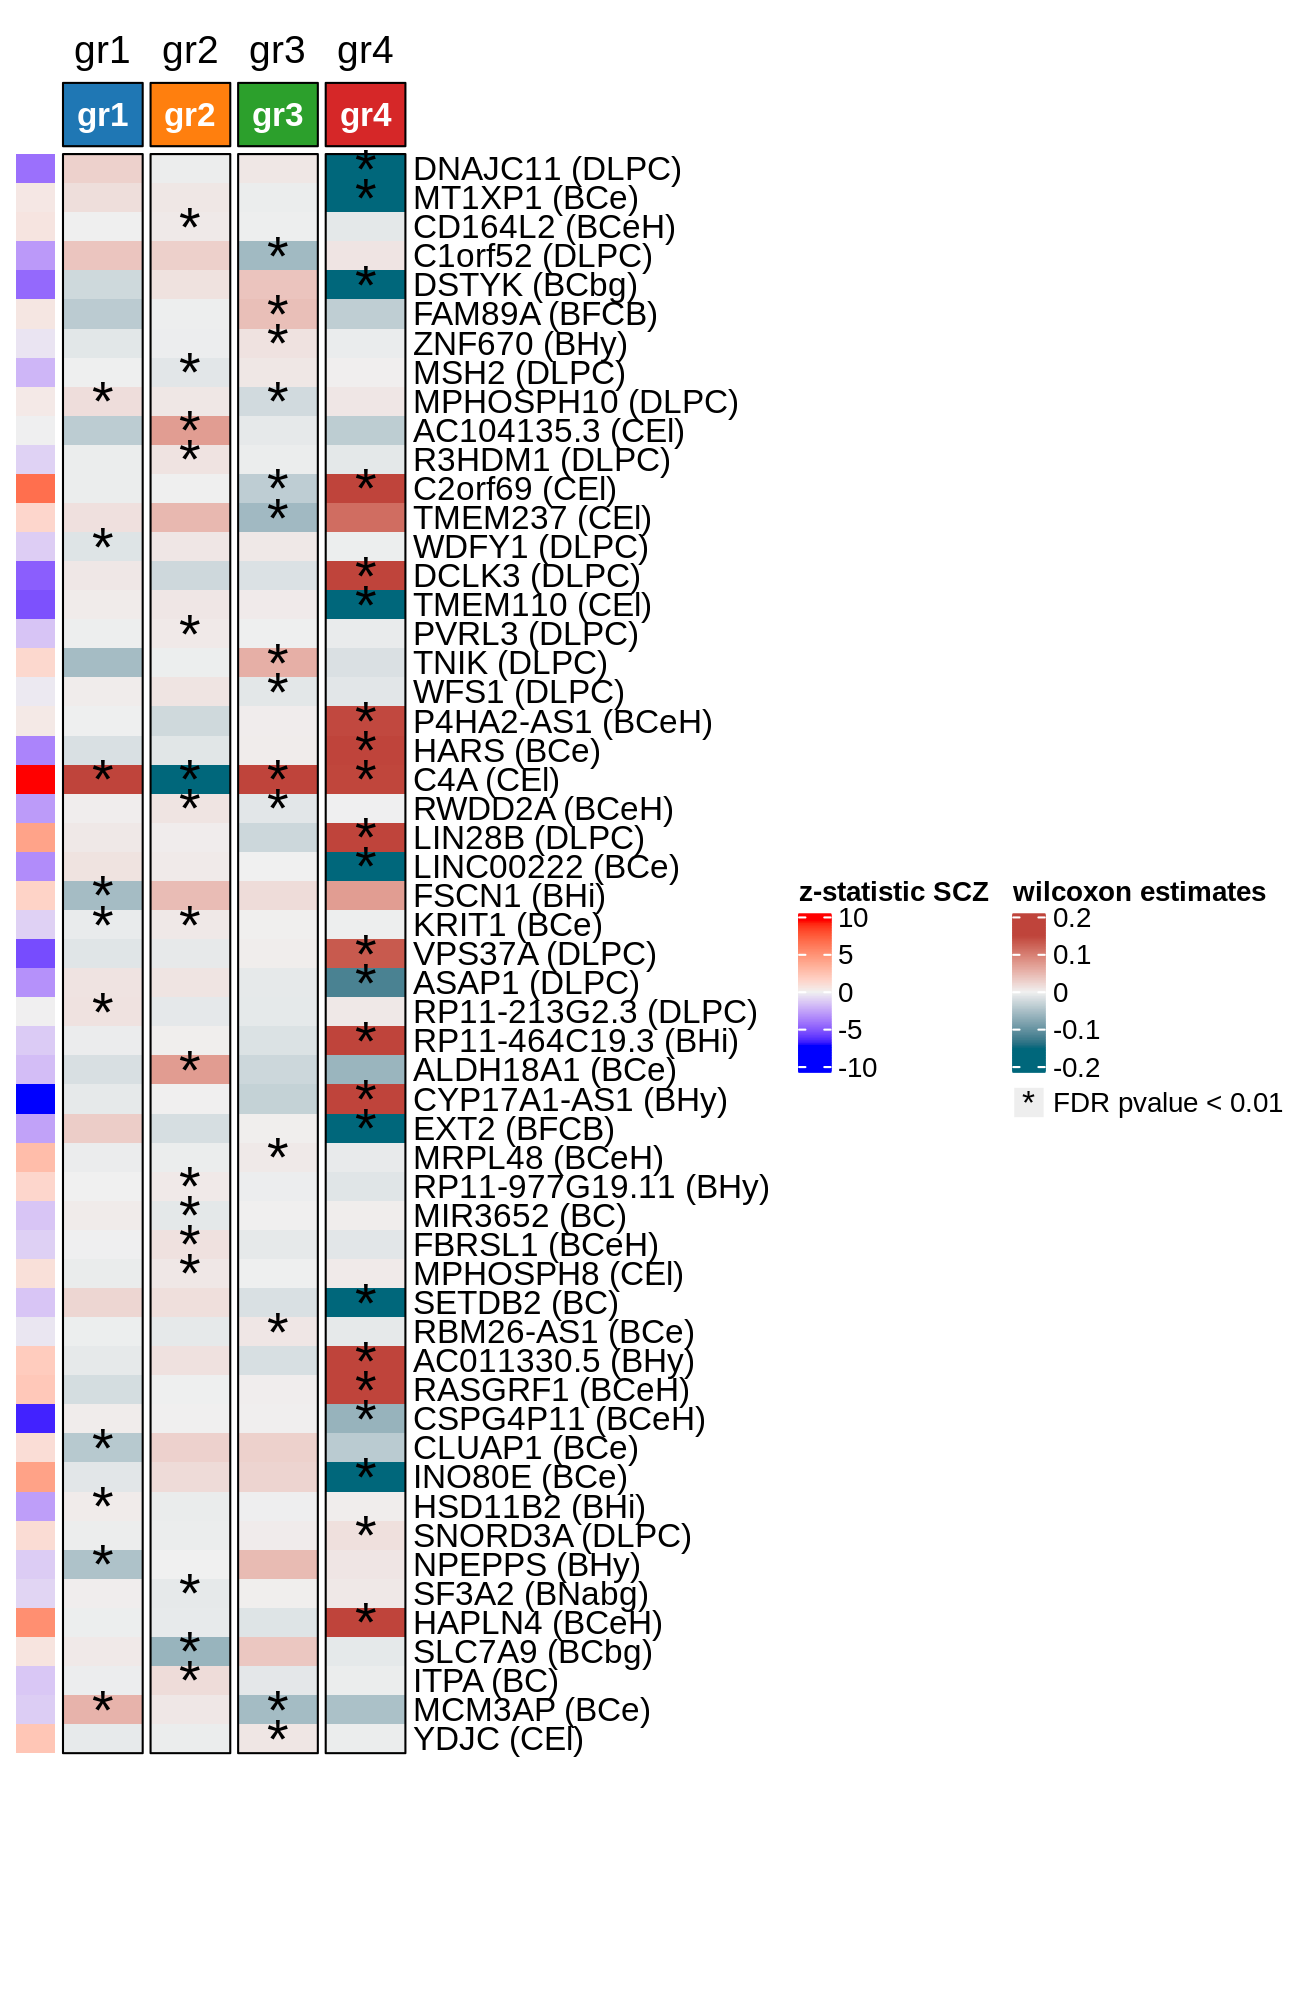

In [12]:
options(repr.plot.width = 6.5, repr.plot.height = 10, repr.plot.res = 200)
pheno_name <- 'SCZ'

P <- length(gr_tot)
# cap
tmp_mat <- as.matrix(feat_est)
val <- abs(quantile(as.vector(feat_est),probs = 0.95))
mat_breaks <- seq(-val, val, length.out = 100)
tmp_mat[tmp_mat>=val] <- val
tmp_mat[tmp_mat<=-val] <- -val

mat_colors_gr <- list(cluster = pal_d3(palette = 'category20')(P))
names(mat_colors_gr$cluster) <- gr_tot

column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))
feat_pvcorr_pch <- feat_pvcorr
feat_pvcorr_pch[feat_pvcorr <= pval_corr_thr] <- '*'
feat_pvcorr_pch[feat_pvcorr > pval_corr_thr] <- ''

estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
zstat_col_fun = colorRamp2(c(min(res_pval_est[,7]), 0, max(res_pval_est[,7])), 
                             c("blue","#F0F0F0", "red"))

row_ha <- rowAnnotation(zstat = res_pval_est[,7],
                        col = list(zstat = zstat_col_fun), 
                        annotation_label = list(zstat = sprintf('z-statistic %s', pheno_name)), 
                        annotation_name_gp = gpar(col = 'white'))

lgd_est <- Legend(title = "wilcoxon estimates", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("FDR pvalue < %s", as.character(pval_corr_thr)))

hm_pl <- Heatmap(tmp_mat, top_annotation = column_ha, 
                 left_annotation = row_ha,  
                 column_split = gr_tot, 
                 cluster_rows = F, cluster_columns = F, show_column_names = F, 
                 col = estimate_col_fun, border = TRUE, show_heatmap_legend = F, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                           grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 20))})

pdf(sprintf('%sheatmap_cluster_genes_WMWest_%s_%s.pdf', outFold, type_data, type_input), width= 6.5, height = 10)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))
dev.off() 
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))

[1] 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 [9] 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.85e-83
[17] 1.70e-62 2.46e-53 3.35e-51 8.97e-47

feat,max_gr,max_gr_id
<chr>,<dbl>,<chr>
C2orf47,1.207599,gr4_vs_all
FTCDNL1,3.436955,gr4_vs_all
HLA-DRB1,4.153314,gr4_vs_all
HLA-DQA1,8.575003,gr2_vs_all
PRRT1,16.479301,gr2_vs_all
RP1-265C24.5,23.074249,gr1_vs_all
ZNF192P1,23.748075,gr1_vs_all
VARS2,23.893723,gr2_vs_all
ZSCAN9,28.830210,gr3_vs_all


feat,max_gr,max_gr_id
<chr>,<dbl>,<chr>
C3,0.6506526,gr1_vs_all
C5,0.6746682,gr1_vs_all
C4,0.9535923,gr2_vs_all
C1,2.1367994,gr3_vs_all
C2,2.4725107,gr2_vs_all


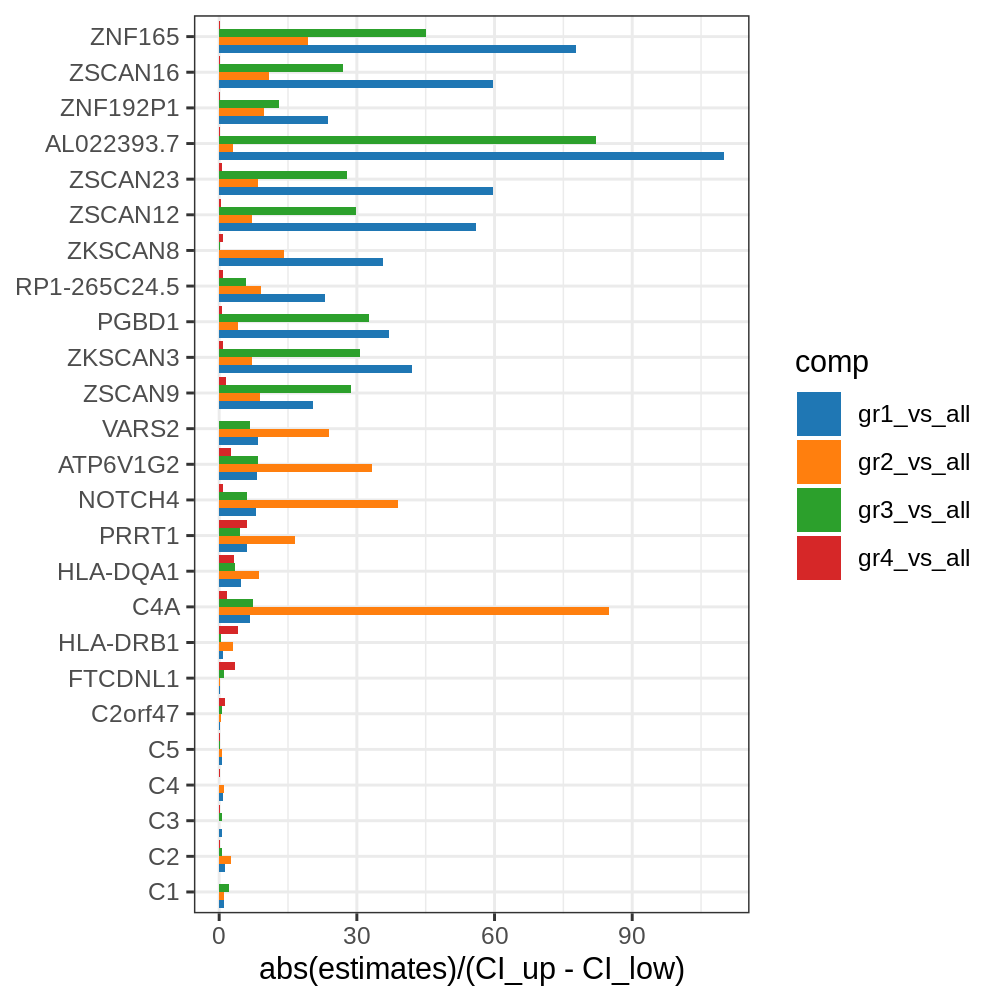

In [16]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

# compare effect size covariates and genes:
feat_sign <- tscore_tot %>% 
    dplyr::filter(pval_corr <= 0.01, tissue == "DLPC_CMC") %>%
    dplyr::arrange(pval, estimates) %>%
    dplyr::group_by(comp) %>%
    dplyr::slice_head(n=5)
feat_sign$pval

df_feat_plot <- tscore_tot[tscore_tot$new_id %in% feat_sign$new_id, ] %>%
    dplyr::mutate(type = "Genes")

df_feat_plot %>% 
    group_by(feat) %>%
    summarise(max_gr = max(abs(estimates)/(CI_up - CI_low)), 
              max_gr_id = comp[which.max(abs(estimates)/(CI_up - CI_low))]) %>%
    arrange(max_gr)

cov_sign <- tscore_feat$test_cov$cov[tscore_feat$test_cov$pval_corr <= 0.05 & 
                                     tscore_feat$test_cov$test_type == "Wilcoxon"]
df_cov_plot <- tscore_feat$test_cov %>% 
    dplyr::filter(cov %in% cov_sign) %>%
    dplyr::mutate(tissue = NA, short = NA, new_id = cov, type = "Covariates") %>%
    dplyr::rename(feat = cov)

df_cov_plot %>% 
    group_by(feat) %>%
    summarise(max_gr = max(abs(estimates)/(CI_up - CI_low)), 
              max_gr_id = comp[which.max(abs(estimates)/(CI_up - CI_low))]) %>%
    arrange(max_gr)

df_plot <- bind_rows(df_feat_plot, df_cov_plot) 
df_plot$feat <- factor(df_plot$feat, 
                       levels = c(unique(cov_sign), 
                                  unique(df_feat_plot$feat[order(df_feat_plot$comp, 
                                                                 abs(df_feat_plot$estimates))])))


pl1 <- ggplot(df_plot, aes(x = abs(estimates)/(CI_up - CI_low), y = feat, fill = comp)) + 
    geom_bar(stat = "identity", position = position_dodge()) + 
    #facet_wrap(.~type, ncol = 1, scales = "free_y") +
    scale_fill_manual(values = gr_color) + 
    theme_bw() +
    theme(axis.title.y = element_blank())
pl1

#pl2 <- ggplot(df_plot, aes(x = -log10(pval), y = feat, fill = comp)) + 
#    geom_bar(stat = "identity", position = position_dodge()) + 
#    #facet_wrap(.~type, ncol = 1, scales = "free_y") +
#    scale_fill_manual(values = gr_color) + 
#    theme_bw() +
#    theme(axis.title.y = element_blank())

#pl <- ggarrange(plotlist = list(pl1, pl2), ncol = 2, common.legend = TRUE)
#pl
ggsave(filename = sprintf('%sest_frac_CI_genes_and_PCs_%s_%s.pdf', outFold, type_data, type_input), 
       plot = pl1, width = 5, height = 5, dpi = 200)
    

In [17]:
# get info
geneInfo <- list()
for(idt in 1:length(tissues_name)){
    t <- tissues_name[idt]
    tmp <- fread(geneInfo_file[idt], data.table = F, h=T, stringsAsFactors = F)
    tmp$short <- df_match$short[df_match$tissue == t]
    tmp$new_id <- paste(tmp$external_gene_name, df_match$short[df_match$tissue == t])
    geneInfo[[idt]] <- tmp
}
geneInfo <- do.call(rbind, geneInfo)
geneInfo <- geneInfo[match(tscore_tot$new_id, geneInfo$new_id),]

length(unique(tscore_tot$new_id))
length(unique(tscore_tot$feat))
nrow(loci_tissues)
nrow(loci_all)


[1] 26836

[1] 12604

[1] 124

[1] 55

In [19]:
table(loci_all$loci_id)


   chr1:16.4-16.9Mb  chr1:204.9-205.4Mb    chr1:231-231.4Mb    chr1:247-247.4Mb 
                  1                   1                   1                   1 
   chr1:27.5-27.9Mb        chr1:6.3-7Mb    chr1:85.5-85.9Mb   chr10:104-105.4Mb 
                  1                   1                   1                   1 
    chr10:3.8-4.2Mb   chr10:97.2-97.6Mb   chr11:43.9-44.3Mb   chr11:73.3-73.7Mb 
                  1                   1                   1                   1 
chr12:104.1-104.5Mb chr12:132.9-133.3Mb   chr12:56.5-56.9Mb     chr13:20-20.4Mb 
                  1                   1                   1                   1 
  chr13:49.8-50.4Mb   chr13:79.8-80.2Mb   chr15:43.4-44.3Mb   chr15:79.2-79.6Mb 
                  1                   1                   1                   1 
  chr15:84.7-85.1Mb   chr16:29.3-30.6Mb     chr16:3.4-3.8Mb   chr16:67.3-67.7Mb 
                  1                   1                   1                   1 
  chr17:18.9-19.3Mb   chr17

[1] "significant genes in MHC across all tissues:  out of 755"
[1] "percentage genes in MHC across all tissues: "


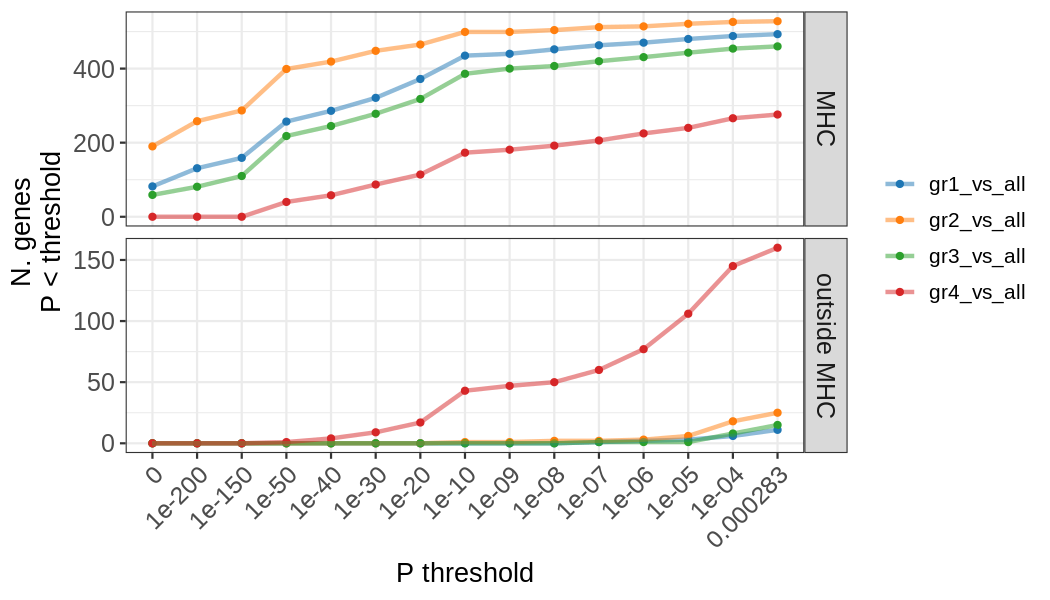

In [20]:
# plot count n. significant genes
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 150)

genes_MHC <- strsplit(loci_all$gene[loci_all$loci_id == 'chr6:24.4-34.9Mb'], split = ',')[[1]]
# percentage of group-specifc genes located in MHC:
print(paste('significant genes in MHC across all tissues:', loci_all$ngenes_withrep[loci_all$loci_id == 'chr6:24.4-34Mb'], 'out of', sum(loci_all$ngenes_withrep)))
print(paste('percentage genes in MHC across all tissues:', loci_all$ngenes_withrep[loci_all$loci_id == 'chr6:24.4-34Mb']/sum(loci_all$ngenes_withrep)))

tscore_tot <- do.call(rbind, tscore_feat$test_feat)
comp <- paste0(gr_tot, '_vs_all')
cl_genes_sign <- tscore_tot[tscore_tot$pval_corr <= pval_corr_thr, ]
cl_genes_sign$class <- 'outside MHC'
cl_genes_sign$class[cl_genes_sign$feat %in% genes_MHC] <- 'MHC'
cl_genes_sign$class <- factor(cl_genes_sign$class, levels = c('MHC', 'outside MHC'))

thr_values <- c(0, 1e-200, 1e-150, 1e-50, 1e-40,1e-30, 1e-20,  
         1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, max(cl_genes_sign$pval))
tmp1 <- unlist(lapply(thr_values, function(x) 
              lapply(comp, function(y) sum(cl_genes_sign$pval <= x & cl_genes_sign$comp == y & cl_genes_sign$class == 'outside MHC'))))
tmp2 <- unlist(lapply(thr_values, function(x) 
              lapply(comp, function(y) sum(cl_genes_sign$pval <= x & cl_genes_sign$comp == y & cl_genes_sign$class == 'MHC'))))
count_thr_pval <- data.frame(count = c(tmp1, tmp2), comp = rep(rep(comp, length(thr_values)), 2), 
                             thr = rep(unlist(lapply(thr_values, function(x) rep(x, length(comp)))), 2), 
                              class = c(rep('outside MHC', length(tmp1)), rep('MHC', length(tmp2))))                                 
count_thr_pval$thr <- factor(as.character(count_thr_pval$thr), 
                               levels = as.character(thr_values))
count_thr_pval$class <- factor(count_thr_pval$class, levels = c('MHC', 'outside MHC'))

pl <- ggplot(data=count_thr_pval, aes(x=thr, y=count, group = comp, color = comp)) +
      geom_point(size = 1.2, alpha = 1)+
      geom_line(size = 1, alpha = 0.5)+
      facet_wrap(class~., scales = 'free_y',ncol =  1, strip.position="right")+
      xlab('P threshold')+
      ylab('N. genes\nP < threshold')+
      scale_color_manual(values = color_gr)+
      theme_bw()+theme(legend.position = "right",
                       strip.text = element_text(size = 12),
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12), axis.text.x = element_text(angle = 45, hjust = 1))
pl
ggsave(filename = sprintf('%sgenesP_FDRthr0.01_count.pdf', outFold), width = 7, height = 4.2,  plot = pl, device = 'pdf')


gr,sp_corr,sp_corr_pval
<fct>,<dbl>,<dbl>
gr1,0.8849012,0.000000e+00
gr2,-0.9397242,0.000000e+00
gr3,0.1348165,3.262643e-03
gr4,0.2978678,2.702089e-10


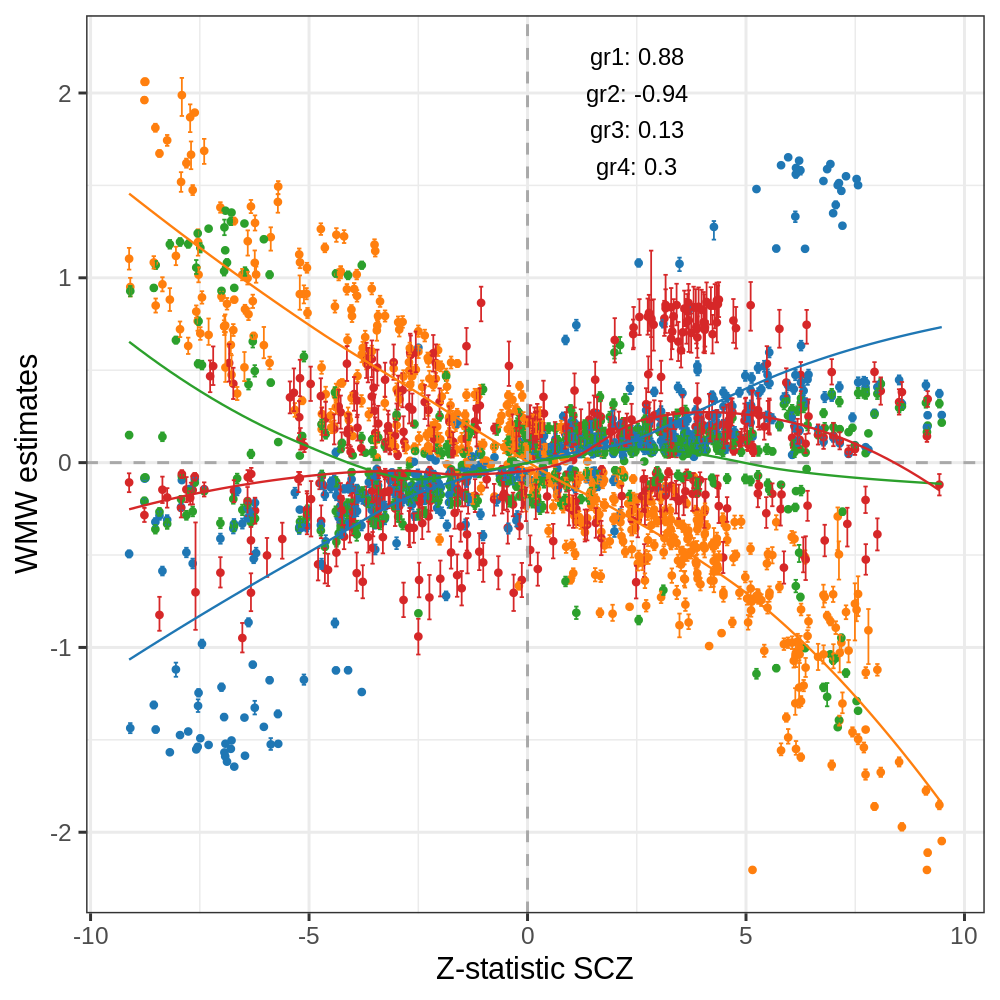

In [25]:
######################################################################
### plot Z-stat versus WMW estimates in tissue used for clustering ###
######################################################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
res_pval <- do.call(rbind, tscore_feat$res_pval)
colnames(res_pval)[7] <- 'Zstat'
res_pval$feat_tisse <- paste0(res_pval$external_gene_name,'_', res_pval$tissue)

cl_genes_sign$Zstat <- res_pval$Zstat[match(cl_genes_sign$feat_tissue, res_pval$feat_tisse)]
cl_genes_sign$gr <- unname(sapply(cl_genes_sign$comp, function(x) strsplit(x, split = '_vs_all')[[1]]))
cl_genes_sign$gr <- factor(cl_genes_sign$gr)

# only significant
df_corr <- cl_genes_sign %>% 
  group_by(gr) %>% 
  summarise(sp_corr = cor(Zstat, estimates, method = 'spearman'), 
            sp_corr_pval = cor.test(Zstat, estimates, method = 'spearman')$p.value)
                                        
df_corr <- as.data.frame(df_corr)
df_corr                                  
df_corr$label <- paste(df_corr$gr,round(df_corr$sp_corr, digits = 2), sep = ': ')
df_corr$x <- 2.5
df_corr$y <- c(2.2,2,1.8, 1.6)

pl1 <-  ggplot(cl_genes_sign, aes(x = Zstat, y = estimates, color = gr, ymin = CI_low, ymax =CI_up))+
  geom_point(size = 0.8)+geom_errorbar(width = 0.1, size = 0.3)+
  ylab('WMW estimates')+xlab('Z-statistic SCZ')+
  geom_vline(xintercept = 0, linetype = 'dashed', color = 'darkgrey')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'darkgrey')+
  geom_smooth(method = 'loess', formula = y~x, se = F, size = 0.4)+
  # geom_smooth(method = 'lm', formula = y~x, se = F, size = 0.4)+
  # scale_color_d3()+
  #geom_text(aes(x=x, y=y, label=label, color = gr))+
  annotate("text", x = df_corr$x, y = df_corr$y, label = df_corr$label, size=3)+
  scale_color_d3()+
  theme_bw()+theme(legend.position = 'none', legend.title = element_blank())
ggsave(filename = sprintf('%stscoreOriginal_tscoreCluster%s_compare_Zstat_est.pdf',outFold,type_cluster), 
       width = 4.5, height = 4.5, plot = pl1, device = 'pdf')

# print:
pl1
               

In [26]:
# count sign. pathways
# remove pathway with opposite effect sign across tissues

tot <- do.call(rbind, pathway_feat$test_feat)
tot %>% group_by(comp) %>% summarise(count = n())

path_tot_res <- tot %>% filter(pval_corr <= pval_corr_thr)
nrow(path_tot_res)
gr <- sort(unique(path_tot_res$comp))
n_gr <- length(gr)

path_gr_res <- lapply(1:n_gr, function(x) path_tot_res[path_tot_res$comp == sprintf('gr%i_vs_all', x),])
# remove discordant results in sign
for(i in 1:n_gr){
  tmp <- path_gr_res[[i]]
  dup_path <- names(which(table(tmp$feat) > 1))
  if(length(dup_path)>0){
    rm_path <- c()
    for(j in 1:length(dup_path)){
      tmp_path <- tmp %>% filter(feat == dup_path[j])
      if(!(all(tmp_path$estimates > 0) | all(tmp_path$estimates < 0))){
        rm_path <- c(rm_path, dup_path[j])
      }
    }
    path_gr_res[[i]] <- path_gr_res[[i]][!path_gr_res[[i]]$feat %in% rm_path,]
  }
}

path_gr_res <- do.call(rbind, path_gr_res)
nrow(path_gr_res)
path_gr_res %>% group_by(comp) %>% summarise(count = n())
length(unique(path_gr_res$feat))
a = path_gr_res %>% group_by(tissue) %>% summarise(count = length(unique(feat)))
sum(a$count)
                      

comp,count
<chr>,<int>
gr1_vs_all,6120
gr2_vs_all,6120
gr3_vs_all,6120
gr4_vs_all,6120


[1] 1145

[1] 1058

comp,count
<chr>,<int>
gr1_vs_all,287
gr2_vs_all,361
gr3_vs_all,253
gr4_vs_all,157


[1] 296

[1] 454

We tested 6120 pathways across 10 tissues, repeated 4 times i.e. for each group This resulted in 1145 significant associations across all groups and tissues. We the removed pathways shared among tissues but having a non concordant association sign which led to 1058 significant results: 287, 361, 253, 157, respectively for a total of 296 unique pathways (non tissue-specific!)

In [27]:
# from wiki and CMCset, remove pathways compoased on a single gene, then recompute FDR
remove_min_path <- function(output_path, min_n_genes = 2){
    ntissues <- length(output_path$tissues)
    for(i in 1:ntissues){
        id_rm <- output_path$res_pval[[i]]$ngenes_tscore < min_n_genes
        output_path$res_pval[[i]] <- output_path$res_pval[[i]][!id_rm,]
        output_path$test_feat[[i]] <- output_path$test_feat[[i]] %>%
            dplyr::filter(feat %in% output_path$res_pval[[i]]$path) %>%
            dplyr::group_by(comp) %>%
            dplyr::mutate(pval_corr = p.adjust(pval, method = "BH")) %>%
            dplyr::ungroup()
    }
    return(output_path)
}

pathway_feat_wiki <- remove_min_path(pathway_feat_wiki)
pathway_feat_CMCset <- remove_min_path(pathway_feat_CMCset)



In [28]:
# count sign. pathways for wiki
# remove pathway with opposite effect sign across tissues

wiki <- do.call(rbind, pathway_feat_wiki$test_feat)
wiki %>% group_by(comp) %>% summarise(count = n())

path_wiki_res <- wiki %>% filter(pval_corr <= pval_corr_thr)
paste("significant results across groups and tissues:", nrow(path_wiki_res))
gr <- sort(unique(path_wiki_res$comp))
n_gr <- length(gr)

wiki_gr_res <- lapply(1:n_gr, function(x) path_wiki_res[path_wiki_res$comp == sprintf('gr%i_vs_all', x),])
# remove discordant results in sign
for(i in 1:n_gr){
  tmp <- wiki_gr_res[[i]]
  dup_path <- names(which(table(tmp$feat) > 1))
  if(length(dup_path)>0){
    rm_path <- c()
    for(j in 1:length(dup_path)){
      tmp_path <- tmp %>% filter(feat == dup_path[j])
      if(!(all(tmp_path$estimates > 0) | all(tmp_path$estimates < 0))){
        rm_path <- c(rm_path, dup_path[j])
      }
    }
    wiki_gr_res[[i]] <- wiki_gr_res[[i]][!wiki_gr_res[[i]]$feat %in% rm_path,]
  }
}

wiki_gr_res <- do.call(rbind, wiki_gr_res)
paste("significant results across groups and tissues with same tissue sign:", nrow(wiki_gr_res))
wiki_gr_res %>% group_by(comp) %>% summarise(count = n())
paste("unique pathways:", length(unique(wiki_gr_res$feat)))
a = wiki_gr_res %>% group_by(tissue) %>% summarise(count = length(unique(feat)))
paste("all pathways:", sum(a$count))
                      

comp,count
<chr>,<int>
gr1_vs_all,2594
gr2_vs_all,2594
gr3_vs_all,2594
gr4_vs_all,2594


[1] "significant results across groups and tissues: 666"

[1] "significant results across groups and tissues with same tissue sign: 554"

comp,count
<chr>,<int>
gr1_vs_all,147
gr2_vs_all,184
gr3_vs_all,130
gr4_vs_all,93


[1] "unique pathways: 86"

[1] "all pathways: 257"

In [29]:
# count sign. pathways for CMC geneset
# remove pathway with opposite effect sign across tissues

CMCset <- do.call(rbind, pathway_feat_CMCset$test_feat)
CMCset %>% group_by(comp) %>% summarise(count = n())

path_CMCset_res <- CMCset %>% filter(pval_corr <= pval_corr_thr)
paste("significant results across groups and tissues:", nrow(path_CMCset_res))
gr <- sort(unique(path_CMCset_res$comp))
n_gr <- length(gr)

CMCset_gr_res <- lapply(1:n_gr, function(x) path_CMCset_res[path_CMCset_res$comp == sprintf('gr%i_vs_all', x),])
# remove discordant results in sign
for(i in 1:n_gr){
  tmp <- CMCset_gr_res[[i]]
  dup_path <- names(which(table(tmp$feat) > 1))
  if(length(dup_path)>0){
    rm_path <- c()
    for(j in 1:length(dup_path)){
      tmp_path <- tmp %>% filter(feat == dup_path[j])
      if(!(all(tmp_path$estimates > 0) | all(tmp_path$estimates < 0))){
        rm_path <- c(rm_path, dup_path[j])
      }
    }
    CMCset_gr_res[[i]] <- CMCset_gr_res[[i]][!CMCset_gr_res[[i]]$feat %in% rm_path,]
  }
}

CMCset_gr_res <- do.call(rbind, CMCset_gr_res)
paste("significant results across groups and tissues with same tissue sign:", nrow(CMCset_gr_res))
CMCset_gr_res %>% group_by(comp) %>% summarise(count = n())
paste("unique pathways:", length(unique(CMCset_gr_res$feat)))
a = CMCset_gr_res %>% group_by(tissue) %>% summarise(count = length(unique(feat)))
paste("all pathways:", sum(a$count))
                      

comp,count
<chr>,<int>
gr1_vs_all,271
gr2_vs_all,271
gr3_vs_all,271
gr4_vs_all,271


[1] "significant results across groups and tissues: 100"

[1] "significant results across groups and tissues with same tissue sign: 100"

comp,count
<chr>,<int>
gr1_vs_all,25
gr2_vs_all,56
gr3_vs_all,18
gr4_vs_all,1


[1] "unique pathways: 59"

[1] "all pathways: 59"


          Brain_Caudate_basal_ganglia           Brain_Cerebellar_Hemisphere 
                                   65                                   154 
                     Brain_Cerebellum                          Brain_Cortex 
                                  196                                    72 
             Brain_Frontal_Cortex_BA9                     Brain_Hippocampus 
                                   60                                    74 
                   Brain_Hypothalamus Brain_Nucleus_accumbens_basal_ganglia 
                                   49                                    33 
    Cells_EBV-transformed_lymphocytes                              DLPC_CMC 
                                   67                                   288 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


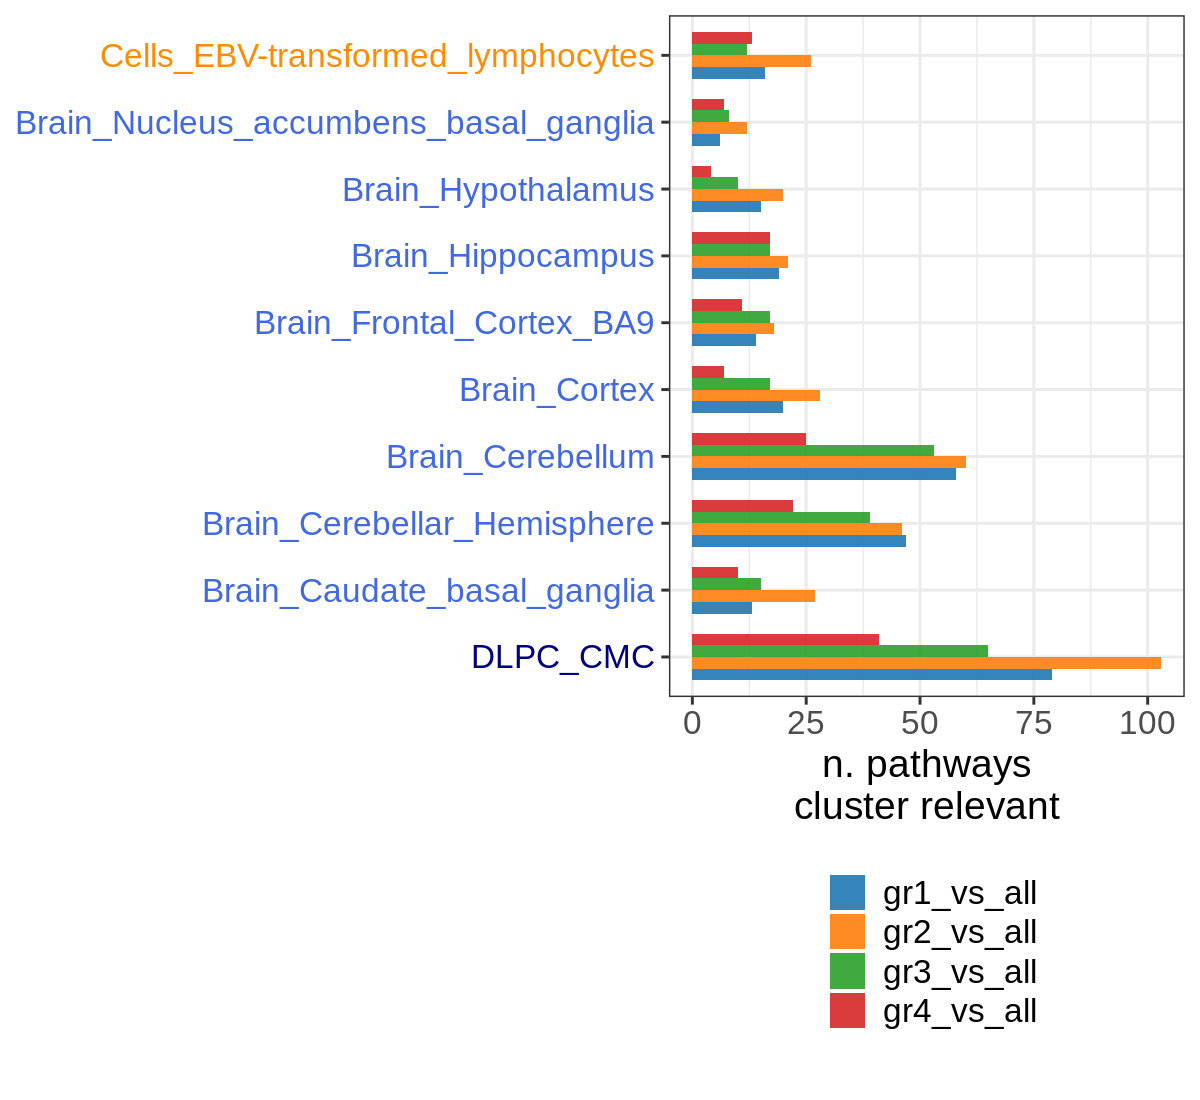

In [30]:
### plot count significant pathways ###
options(repr.plot.width = 6, repr.plot.height = 5.5, repr.plot.res = 200)

tmp <- path_gr_res %>% 
    mutate(tissue = factor(tissue, levels = tissues_name), 
           comp = factor(comp, levels = paste0(gr_tot, '_vs_all')))
df <- tmp %>% group_by(tissue, comp) %>% tally()
newcolours <-  color_tissues$color[match(tissues_name, color_tissues$tissues)]
color_gr <- pal_d3("category10")(length(gr_tot))
table(path_gr_res$tissue)

pl <- ggplot(data = df, aes(x = tissue, y = n, fill = comp))+
  geom_bar(alpha = 0.9, width = 0.7, stat = 'identity', position = position_dodge())+
  ylab('n. pathways\ncluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'bottom', legend.key.size = unit(0.5, "cm"), 
        legend.text = element_text(size = 12), legend.title = element_blank(), 
        axis.title.y = element_blank(),  axis.title.x = element_text(size = 14), 
        axis.text.y = element_text(colour = newcolours, size = 12), 
        axis.text.x = element_text(size = 12))+
  guides(fill=guide_legend(nrow=5))+
  scale_fill_manual(values = color_gr)+
  # scale_fill_d3()+
  coord_flip() 
pl

ggsave(filename = sprintf('%scluster_npathways_alltissues_%s_%s.pdf', outFold, type_data, type_input), 
       plot = pl, width = 6, height = 5.5, dpi = 200)

In [31]:
### function to get improvement of pathways from genes ###
get_improvement <- function(pathway_test, tscore_test, gr, t, pathway_struct){
    
    tmp_path <- pathway_test %>% 
    filter(comp %in% gr, tissue %in% t) %>%
    mutate(db = pathway_struct$name[match(feat,pathway_struct$path)], 
           genes = pathway_struct$gene_name[match(feat,pathway_struct$path)], 
           pval_genes = NA, estimates_genes = NA, improvement = NA, 
           diff_pval_bestgene = NA, ngenes = NA) %>%
    filter(!is.na(genes))
    
    tmp_tscore <- tscore_test %>% filter(comp %in% gr, tissue %in% t)
    if(nrow(tmp_path)>0){
    for(i in 1:nrow(tmp_path)){

        genes <- strsplit(tmp_path$genes[i], split = ',')[[1]]
        filt_genes <- tmp_tscore[match(genes, tmp_tscore$feat),]
        tmp_path$improvement[i] <- all(tmp_path$pval[i] < filt_genes$pval) 
        tmp_path$pval_genes[i] <- paste0(filt_genes$pval, collapse = ',') 
        tmp_path$estimates_genes[i] <- paste0(round(filt_genes$estimates, digits = 5), collapse = ',') 
        tmp_path$diff_pval_bestgene[i] <- tmp_path$pval[i] - min(filt_genes$pval)
        tmp_path$ngenes[i] <- length(genes)
    }
    }
    
    return(tmp_path)

}


In [32]:
# get pathway structure (wiki and CMCgene set)
get_path_list <- function(path_structure, path_structure_name){
  df <- data.frame(path = sapply(path_structure[[1]], function(x) x$path$path), 
                   ngenes_tscore = sapply(path_structure[[1]], function(x) x$path$ngenes_tscore), 
                   ngenes_path = sapply(path_structure[[1]], function(x) x$path$ngenes_path))
  df$coverage <- df$ngenes_tscore/df$ngenes_path
  
  df$gene_name <- sapply(path_structure[[1]], function(x) paste0(x$tscore$external_gene_name, collapse = ','))
  df$name <- path_structure_name
  return(df)  
}

path_wiki_struct <- list()
for(i in seq_len(length(tissues_name))){
    t <- tissues_name[i]
    wiki_pvalresFile <- sprintf('Meta_Analysis_SCZ/%s/pval_Dx_pheno_covCorr_customPath_WikiPath2019Human.RData', t)
    wiki_pval <- get(load(wiki_pvalresFile))
    path_wiki_struct[[i]] <- get_path_list(wiki_pval$info_pathScore, 'WikiPathways')
    path_wiki_struct[[i]]$tissue <- t
}
                         
CMCSet_struct <- list()
t <- "DLPC_CMC"
CMCSet_pvalresFile <- 'Meta_Analysis_SCZ/DLPC_CMC/pval_Dx_pheno_covCorr_customPath_CMC_GeneSets.RData'
CMCSet_pval <- get(load(CMCSet_pvalresFile))
CMCSet_struct <- get_path_list(CMCSet_pval$info_pathScore, 'CMCGeneSet')
CMCSet_struct$tissue <- t                         


In [33]:
gr_tot <- paste0('gr', sort(unique(clust_res$cl_best$gr)))
pathway_test <- path_gr_res
tscore_test <-  do.call(rbind, tscore_feat$test_feat)

path_anno <- list()
for(idg in 1:length(gr_tot)){

    gr <- paste0(gr_tot[idg], '_vs_all')
    print(gr)
    tmp <- list()
    for(idt in 1:length(tissues_name)){
        t <- tissues_name[idt]
        pathway_struct <- read.table(sprintf('clustering_res_matchUKBB_corrPCs/%s/selected_pathways_JSthr0.2.txt', t), h=T, stringsAsFactors = F)
        tmp[[idt]] <- get_improvement(path_gr_res, tscore_test, gr, t, pathway_struct)
    }
    path_anno[[idg]] <- do.call(rbind, tmp)
}
path_anno <- do.call(rbind, path_anno)
path_anno$genes_in_mhc <- NA
for(i in 1:nrow(path_anno)){

    genes <- strsplit(path_anno$genes[i], split = ',')[[1]]
    t <- path_anno$tissue[i]
    tmp <- geneInfo[geneInfo$external_gene_name %in% genes, ]
    tmp <- tmp[!duplicated(tmp$ensembl_gene_id), ]
    path_anno$genes_in_mhc[i] <- F
    if(any(tmp$chrom == 'chr6' & tmp$start_position >= 26000000 & tmp$end_position <= 34000000)){
        path_anno$genes_in_mhc[i] <- T
    }
    
}

[1] "gr1_vs_all"
[1] "gr2_vs_all"
[1] "gr3_vs_all"
[1] "gr4_vs_all"


In [34]:
table(path_anno$genes_in_mhc, path_anno$improvement)

       
        FALSE TRUE
  FALSE    32   28
  TRUE    991    7

In [35]:
wiki_anno <- list()
for(idg in 1:length(gr_tot)){

    gr <- paste0(gr_tot[idg], '_vs_all')
    print(gr)
    tmp <- list()
    for(idt in 1:length(tissues_name)){
        t <- tissues_name[idt]
        pathway_struct <- path_wiki_struct[[idt]]
        tmp[[idt]] <- get_improvement(wiki_gr_res, tscore_test, gr, t, pathway_struct)
    }
    wiki_anno[[idg]] <- do.call(rbind, tmp)
}
wiki_anno <- do.call(rbind, wiki_anno)
wiki_anno$genes_in_mhc <- NA
for(i in 1:nrow(wiki_anno)){

    genes <- strsplit(wiki_anno$genes[i], split = ',')[[1]]
    t <- wiki_anno$tissue[i]
    tmp <- geneInfo[geneInfo$external_gene_name %in% genes, ]
    tmp <- tmp[!duplicated(tmp$ensembl_gene_id), ]
    wiki_anno$genes_in_mhc[i] <- F
    if(any(tmp$chrom == 'chr6' & tmp$start_position >= 26000000 & tmp$end_position <= 34000000)){
        wiki_anno$genes_in_mhc[i] <- T
    }
    
}

[1] "gr1_vs_all"
[1] "gr2_vs_all"
[1] "gr3_vs_all"
[1] "gr4_vs_all"


In [36]:
table(wiki_anno$genes_in_mhc, wiki_anno$improvement)

       
        FALSE TRUE
  FALSE     9    9
  TRUE    528    8

In [37]:
CMCSet_anno <- list()
for(idg in 1:length(gr_tot)){

    gr <- paste0(gr_tot[idg], '_vs_all')
    print(gr)
    t <- "DLPC_CMC"
    pathway_struct <- CMCSet_struct
    tmp <- get_improvement(CMCset_gr_res, tscore_test, gr, t, pathway_struct)
    CMCSet_anno[[idg]] <- tmp
}
CMCSet_anno <- do.call(rbind, CMCSet_anno)
CMCSet_anno$genes_in_mhc <- NA
for(i in 1:nrow(CMCSet_anno)){

    genes <- strsplit(CMCSet_anno$genes[i], split = ',')[[1]]
    t <- CMCSet_anno$tissue[i]
    tmp <- geneInfo[geneInfo$external_gene_name %in% genes, ]
    tmp <- tmp[!duplicated(tmp$ensembl_gene_id), ]
    CMCSet_anno$genes_in_mhc[i] <- F
    if(any(tmp$chrom == 'chr6' & tmp$start_position >= 26000000 & tmp$end_position <= 34000000)){
        CMCSet_anno$genes_in_mhc[i] <- T
    }
    
}



[1] "gr1_vs_all"
[1] "gr2_vs_all"
[1] "gr3_vs_all"
[1] "gr4_vs_all"


In [50]:
table(path_anno$pval_corr <= 0.01, path_anno$improvement)
a=path_anno[path_anno$pval_corr <= 0.01 & path_anno$improvement,]
table(a$comp)
b = path_anno %>% dplyr::filter(improvement, !genes_in_mhc, pval_corr <= 0.01) %>% dplyr::arrange(estimates)
dim(b)
length(unique(b$feat))
b
# path_anno[!path_anno$genes_in_mhc & !path_anno$improvement, ]

      
       FALSE TRUE
  TRUE  1023   35


gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all 
         9          8          9          9 

[1] 28 17

[1] 25

feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,db,genes,pval_genes,estimates_genes,improvement,diff_pval_bestgene,ngenes,genes_in_mhc
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<int>,<lgl>
Golgi cisterna membrane,gr4_vs_all,6.63e-06,-0.20648598,-0.29592809,-0.11701039,4.069162e-04,2.325236e-04,Brain_Caudate_basal_ganglia,GO,"SAR1B,HACE1,INPP5E,CSGALNACT2,FUT3","0.0979,0.000319,0.25,0.0279,0.105","-0.07037,-0.1315,-0.02673,-0.05988,-0.07216",TRUE,-0.00031237,5,FALSE
cellular respiration,gr4_vs_all,1.26e-05,-0.19951095,-0.28828190,-0.11035170,7.694400e-04,3.524153e-04,DLPC_CMC,GO,"FASTKD1,NDUFS1,PPARGC1A,NDUFS4,TBRG4,SLC25A13,NFATC3,COX10,FASTKD5","0.0548,0.472,0.0729,0.759,0.0285,0.00578,0.21,0.155,0.185","-0.07865,0.01677,-0.07405,-0.01366,-0.06171,-0.04985,-0.03219,-0.06515,-0.04997",TRUE,-0.00576740,9,FALSE
"oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor",gr4_vs_all,1.23e-05,-0.19927712,-0.28797305,-0.10998316,6.710333e-04,3.834476e-04,Brain_Caudate_basal_ganglia,GO,"ALDH8A1,HTATIP2,ALDH3A1,ALDH16A1","0.000437,0.251,0.0228,0.0889","-0.11066,-0.05217,-0.06831,-0.06747",TRUE,-0.00042470,4,FALSE
mRNA processing,gr4_vs_all,9.32e-06,-0.19726986,-0.28424821,-0.11025096,2.211947e-04,1.723595e-04,Brain_Hippocampus,GO,"SSU72,ADAR,IWS1,PPP4R2,PTCD2,HNRNPA2B1,MAGOHB,RBM26","0.251,0.459,0.431,0.0573,0.0513,0.0955,0.168,0.0919","-0.01127,-0.03055,-0.01474,-0.08356,-0.07622,-0.07481,-0.06321,-0.06303",TRUE,-0.05129068,8,FALSE
negative regulation of cell cycle,gr4_vs_all,1.86e-04,-0.16628152,-0.25362236,-0.07916710,8.311024e-03,4.651904e-03,DLPC_CMC,GO,"HPGD,CASP3,PTPRK,RPS6KA2,CDK6,THAP5,SIPA1,PRDM4,RB1,BMP4,PPP1R13B,RNF167,LILRB1,BMP7,MAPK12","0.255,0.384,0.631,0.838,0.864,0.194,0.00286,0.235,0.419,0.494,0.000644,0.462,0.331,0.0576,0.505","-0.05166,0.03693,0.00867,-0.00366,-0.00228,-0.05628,-0.07319,-0.04772,-0.03648,-0.0188,-0.14465,-0.02396,-0.01942,-0.0856,-0.028",TRUE,-0.00045800,15,FALSE
cell projection organization,gr1_vs_all,2.40e-07,-0.07078849,-0.09762656,-0.04392249,4.003404e-06,4.375814e-06,Brain_Cerebellum,GO,"TTC30A,BOC,TSC1,CLUAP1","0.224,0.00539,0.0367,9.89e-05","-0.01362,-0.03963,-0.02263,-0.03915",TRUE,-0.00009866,4,FALSE
peristalsis,gr2_vs_all,2.24e-04,-0.06360028,-0.09739054,-0.02983622,3.764844e-03,5.564312e-03,DLPC_CMC,GO,"AGT,DRD1,SSTR2","0.000681,0.133,0.0341","-0.05127,-0.02599,-0.03665",TRUE,-0.00045700,3,FALSE
antiporter activity,gr3_vs_all,4.58e-06,-0.06331574,-0.09036965,-0.03622218,1.498314e-04,1.342490e-04,DLPC_CMC,GO,"CLCN6,CLCN3,SLC25A16,SLC24A4,SLC7A6","0.0284,0.00134,0.757,0.00277,0.835","-0.02721,-0.02307,-0.00183,-0.04186,-0.00214",TRUE,-0.00133542,5,FALSE
cell motility,gr1_vs_all,1.84e-05,-0.06016829,-0.08768134,-0.03263963,2.729333e-04,3.359179e-04,Brain_Hippocampus,GO,"FSCN1,PTK2,TGFBR1","0.000182,0.195,0.0631","-0.05205,-0.01026,-0.02522",TRUE,-0.00016360,3,FALSE


In [48]:
CMCSet_anno[CMCSet_anno$pval_corr <= 0.01 & !CMCSet_anno$genes_in_mhc,]
wiki_anno[wiki_anno$pval_corr <= 0.01 & !wiki_anno$genes_in_mhc & wiki_anno$improvement,]

feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,db,genes,pval_genes,estimates_genes,improvement,diff_pval_bestgene,ngenes,genes_in_mhc
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<int>,<lgl>
HBA:Lateral_Hemisphere_localMarker(top200)_IN_Cerebellar_Cortex,gr2_vs_all,1.47e-03,0.05465832,0.0209698,0.08828216,7.11375e-03,1.42800e-02,DLPC_CMC,CMCGeneSet,"DFFB,TSTD1,EPCAM,ROBO1,SNCA,CCNO,CNOT8,KIAA0319,LRRC16A,MRAP2,OSTM1,PPIL6,WIPF3,DPY19L1,CDK6,C8orf34,TRIB1,ST3GAL1,TEK,GOLM1,ASS1,ATOH7,EXOC6,CRTAC1,VAX1,LRRC56,C1RL,LGALS3,WFIKKN1,MGRN1,TMEM132E,SSTR2,RBBP8,CABP7","0.332,0.31,0.0157,0.61,0.949,0.377,0.972,3.14e-06,3.14e-83,0.661,0.579,0.0372,0.755,0.31,0.0578,0.649,0.897,0.00173,0.133,0.479,0.287,0.333,0.866,0.939,0.728,0.231,0.43,0.157,0.218,0.169,0.807,0.0341,0.979,0.166","0.01664,0.01384,-0.01668,-0.00206,0.00081,0.00508,6e-04,-0.08133,0.34189,-0.00548,0.00587,0.03559,0.00331,0.0163,0.0091,0.00779,0.00224,-0.04937,0.02397,0.00743,0.0174,-0.01489,0.00182,-0.00129,-0.00329,0.00844,0.01112,0.00912,-0.01437,-0.00553,0.00414,-0.03665,-0.00041,0.02193",FALSE,1.47e-03,34,FALSE
GWAS:PGC2 SCZ,gr4_vs_all,4.23e-15,-0.36475462,-0.4551152,-0.27431932,1.14633e-12,1.53408e-13,DLPC_CMC,CMCGeneSet,"SLC45A1,CD46,SDCCAG8,FANCL,CYP26B1,DPP4,ANKRD44,SF3B1,HSPD1,TYW5,C2orf47,CUL3,EFHD1,GIGYF2,C2orf82,TRANK1,NISCH,NT5DC2,GNL3,GLT8D1,NEK4,TMEM110,THOC7,PPP2R3A,PCCB,SLC35G2,NCK1,DNAJC19,SLC39A8,NEK1,CLCN3,C4orf27,MAN2A1,KDM3B,REEP2,CTNNA1,CD14,NDUFA2,WDR55,ZMAT2,PCDHA2,PCDHA4,PCDHA6,PCDHA7,PCDHA8,PCDHA9,PCDHA10,GALNT10,SNAP91,FUT9,MAD1L1,MPP6,DFNA5,OSBPL3,EPHX2,TSNARE1,ARL3,WBP1L,C10orf32,AS3MT,CNNM2,NT5C2,INA,PCGF6,ZNF408,SNX19,TMTC1,STAT6,OGFOD2,MPHOSPH9,CDK2AP1,RGS6,TRMT61A,KLC1,PPP1R13B,IREB2,PSMA4,ADAMTSL3,EFTUD1P1,UBE2Q2P1,ZSCAN2,MAN2A2,GRIN2A,INO80E,DOC2A,MAPK3,ENKD1,RANBP10,NFATC3,PLA2G15,SLC7A6,SRR,TSR1,SGSM2,TOM1L2,ATPAF2,DRG2,MYO15A,NCAN,MAU2,GATAD2A,YJEFN3,EP300,CHADL,RANGAP1,LINC00634,WBP2NL,NAGA,NDUFA6","3e-04,0.168,0.000303,0.0115,0.742,0.669,0.276,0.0738,0.699,3.07e-41,3.35e-51,0.409,0.707,0.347,0.408,0.0108,1.3e-06,0.345,0.475,3.93e-13,1.92e-17,7.29e-17,0.0255,0.0251,0.103,0.277,0.963,0.316,0.532,0.0197,0.00016,0.00298,0.669,0.0204,0.00841,0.765,0.119,3.87e-07,0.000381,3.42e-07,8.93e-07,0.000139,0.885,2.28e-06,2.51e-06,0.422,0.000224,0.0718,0.616,0.239,0.0791,0.262,0.87,0.0488,0.399,0.00759,2.9e-05,2.75e-27,3.16e-20,2.59e-25,6.21e-30,0.000488,0.189,0.311,0.111,0.0656,0.943,0.00248,0.226,0.473,0.358,0.00408,0.511,0.0738,0.000644,0.885,0.2,0.338,0.00136,0.12,0.00779,0.163,0.46,5.1e-11,6.33e-09,0.000506,0.986,0.179,0.21,0.804,0.773,0.714,0.44,0.0984,0.416,0.22,0.829,0.727,0.00065,8.24e-08,1.34e-08,4.45e-09,0.133,0.987,0.0226,0.374,0.987,0.771,0.973","-0.16392,-0.05355,-0.10794,0.11786,-0.01287,-0.01839,0.05117,0.0248,0.00247,-0.50218,-0.7017,-0.03304,0.01625,0.04231,0.01984,0.119,-0.13506,-0.02122,0.01961,-0.23254,0.27927,-0.11134,-0.03527,0.05784,-0.02864,-0.01522,-0.0021,0.03436,-0.01903,0.0649,0.10199,0.11582,0.01814,0.10452,-0.05934,-0.0135,-0.04689,0.19776,-0.13402,-0.0948,-0.12198,-0.04879,-0.00279,-0.09376,-0.17467,0.01532,-0.04783,0.0833,-0.02005,0.05427,-0.07937,-0.04096,-0.00313,-0.07802,-0.01539,-0.11201,0.2007,0.37793,-0.24783,-0.27394,0.5222,0.14749,0.018,0.02492,-0.03151,-0.05011,0.0033,0.09823,-0.01616,-0.02842,-0.02651,-0.13391,-0.02273,-0.08475,-0.14465,-0.00654,0.02472,0.04429,-0.06841,-0.03662,0.03477,-0.06137,0.02082,-0.17244,-0.25211,-0.05993,-0.00054,0.03334,-0.03219,-0.01089,-0.00953,0.0047,-0.02078,-0.04956,0.02897,0.02514,0.00825,0.01024,0.15216,-0.11811,-0.08914,-0.21866,0.05566,0.00052,-0.06188,0.03398,-0.00039,0.01046,0.00028",FALSE,4.23e-15,109,FALSE


feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,db,genes,pval_genes,estimates_genes,improvement,diff_pval_bestgene,ngenes,genes_in_mhc
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<int>,<lgl>
Aryl Hydrocarbon Receptor WP2586,gr1_vs_all,3.43e-04,-0.04976493,-0.07697917,-0.02252208,0.005632421,5.666957e-03,Brain_Cerebellum,WikiPathways,"PSRC1,GCLC,HRAS","0.00137,0.304,0.00985","-0.04446,-0.01459,-0.02042",TRUE,-0.001027000,3,FALSE
Disorders of Folate Metabolism and Transport WP4259,gr3_vs_all,6.36e-06,-0.06335540,-0.09086018,-0.03587052,0.000072875,8.256000e-05,Brain_Cerebellar_Hemisphere,WikiPathways,"ATIC,DHFR,FTCD","0.00318,0.0155,0.0113","-0.04036,-0.02743,-0.03398",TRUE,-0.003173640,3,FALSE
Amino Acid metabolism WP3925,gr3_vs_all,2.08e-04,-0.05159707,-0.07887939,-0.02432638,0.003415579,3.676279e-03,Brain_Cerebellum,WikiPathways,"ACADM,SUCLG1,HIBCH,IDH1,CPS1,ADH5,GSR,ALDH18A1,GOT1,OAT,PDHX,FAH,CBS,FTCD","0.0939,0.171,0.787,0.69,0.00206,0.39,0.133,0.0786,0.144,0.922,0.0755,0.121,0.404,0.00644","-0.0234,0.01418,0.00312,-0.00556,-0.01388,0.01013,-0.01122,-0.02495,-0.02047,0.00134,-0.01381,-0.01582,0.01093,-0.03801",TRUE,-0.001852000,14,FALSE
Disorders of Folate Metabolism and Transport WP4259,gr3_vs_all,7.37e-04,-0.04703172,-0.07434476,-0.01970128,0.009658579,9.184154e-03,Brain_Cortex,WikiPathways,"ATIC,DHFR,FTCD","0.249,0.0865,0.00135","-0.01633,-0.01549,-0.04309",TRUE,-0.000613000,3,FALSE
Disorders of Folate Metabolism and Transport WP4259,gr3_vs_all,1.18e-04,-0.05361051,-0.08085593,-0.02633117,0.003792857,4.899034e-03,Brain_Nucleus_accumbens_basal_ganglia,WikiPathways,"ATIC,DHFR,FTCD","0.0102,0.14,0.00127","-0.03481,-0.01461,-0.03177",TRUE,-0.001152000,3,FALSE
IL-5 Signaling Pathway WP127,gr4_vs_all,1.18e-04,0.16843707,0.08266174,0.25438050,0.003346909,2.135238e-03,Brain_Cerebellum,WikiPathways,"JAK1,FOXO3,LYN,MAPT","0.545,0.109,0.0183,0.00445","0.01901,0.06966,0.10045,0.07755",TRUE,-0.004332000,4,FALSE
SREBF and miR33 in cholesterol and lipid homeostasis WP2011,gr4_vs_all,2.94e-04,-0.16171046,-0.24949803,-0.07405611,0.007056000,4.910769e-03,Brain_Cerebellum,WikiPathways,"ABCA1,SIRT6,LDLR","0.0415,0.259,0.00509","-0.07211,-0.02702,-0.06221",TRUE,-0.004796000,3,FALSE
Oxidative phosphorylation WP623,gr4_vs_all,4.18e-07,-0.23402047,-0.32404844,-0.14381399,0.000008360,8.833208e-06,Brain_Hippocampus,WikiPathways,"NDUFS4,NDUFA2","0.0185,7.87e-07","-0.10942,-0.05253",TRUE,-0.000000369,2,FALSE
IL-2 Signaling Pathway WP49,gr4_vs_all,3.57e-07,-0.19806911,-0.28111392,-0.11808212,0.000011985,8.118444e-06,Cells_EBV-transformed_lymphocytes,WikiPathways,"LCK,MAPK3","0.0725,8.45e-07","-0.0098,-0.16701",TRUE,-0.000000488,2,FALSE


35 pathways show any improvement and 28 pathways are composed of no genes in MHC locus (25 are unique)

In [51]:
# get pathway sign and create matrix
path_unique <- unique(path_anno$feat)
N_path <- length(unique(path_anno$feat))

feat_est <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_CIl <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_CIu <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_pvcorr <- matrix(NA, nrow = N_path ,ncol = length(gr_tot))
new_name <- vector(mode = 'numeric', length = N_path)


for(i in 1:N_path){
# i=269
path <- path_unique[i]
tmp <- tot %>% filter(feat %in% path)
tmp <- tmp %>% filter(pval_corr <= 0.01)
top_t <- tmp[order(tmp$pval), ]
top_t <- tmp[order(abs(tmp$estimates), decreasing = T),]

t <- top_t$tissue[1]
short <- get_short_name(t)
new_name[i] <- paste(path, short)

feat_est[i,] <- tot$estimates[tot$tissue == t & tot$feat == path]
feat_CIl[i,] <- tot$CI_low[tot$tissue == t & tot$feat == path]
feat_CIu[i,] <- tot$CI_up[tot$tissue == t & tot$feat == path]
feat_pvcorr[i,] <- tot$pval_corr[tot$tissue == t & tot$feat == path]

}

rownames(feat_est) <- rownames(feat_CIl) <- rownames(feat_CIu) <- rownames(feat_pvcorr) <- new_name
colnames(feat_est) <- colnames(feat_CIl) <- colnames(feat_CIu) <- colnames(feat_pvcorr) <- gr_tot

res_pval_path <- do.call(rbind, pathway_feat$res_pval) 
res_pval_path <- left_join(res_pval_path, df_match) %>%
    mutate(new_id = paste(path, short))
res_pval_est <- res_pval_path[match(new_name, res_pval_path$new_id), ]

# create summary table and save

tmp <- path_anno %>% mutate(new_id = paste0(feat, '_', tissue))
unique_feat <- unique(tmp$new_id)
df <- data.frame(pathway = rep(NA,length(unique_feat)) , collection = rep(NA,length(unique_feat)), 
                 tissue= rep(NA,length(unique_feat)),  genes= rep(NA,length(unique_feat)), 
                 improvement_g = rep(NA,length(unique_feat)),genes_in_mhc = rep(NA,length(unique_feat)), 
                 Zstat= rep(NA,length(unique_feat)), 
                 comp_sign= rep(NA,length(unique_feat)), 
                 WMW_est= rep(NA,length(unique_feat)), WMW_pvalue= rep(NA,length(unique_feat)))
for(i in 1:length(unique_feat)){
    
    tmp_i <- tmp %>% filter(new_id == unique_feat[i])
    df$pathway[i] <- tmp_i$feat[1]
    df$collection[i] <- tmp_i$db[1]
    df$tissue[i] <- tmp_i$tissue[1]
    df$genes[i] <- tmp_i$genes[1]
    df$improvement_g[i] <- paste0(tmp_i$improvement, collapse =  ',')
    df$genes_in_mhc[i] <- unique(tmp_i$genes_in_mhc)
    df$Zstat[i] <- res_pval_path$Dx_z[res_pval_path$path == tmp_i$feat[1] & 
                                              res_pval_path$tissue ==  tmp_i$tissue[1]]
    df$comp_sign[i] <- paste0(sapply(tmp_i$comp, function(x) strsplit(x, split = '_vs_all')[[1]]), collapse =  ',')
    df$WMW_est[i] <- paste0(round(tmp_i$estimates, 4), collapse =  ',')
    df$WMW_pvalue[i] <- paste0(tmp_i$pval, collapse =  ',')
    
}

write.table(df, file = 'clustering_res_matchUKBB_corrPCs/DLPC_CMC/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_summary.txt', 
           quote = F, sep = '\t', col.names = T, row.names = F)
     

Joining, by = "tissue"



In [52]:
# create summary table and save (wiki)
res_pval_wiki <- do.call(rbind, pathway_feat_wiki$res_pval) 
res_pval_wiki <- left_join(res_pval_wiki, df_match) %>%
    mutate(new_id = paste(path, short))

tmp <- wiki_anno %>% mutate(new_id = paste0(feat, '_', tissue))
unique_feat <- unique(tmp$new_id)
df <- data.frame(pathway = rep(NA,length(unique_feat)) , collection = rep(NA,length(unique_feat)), 
                 tissue= rep(NA,length(unique_feat)),  genes= rep(NA,length(unique_feat)), 
                 improvement_g = rep(NA,length(unique_feat)),genes_in_mhc = rep(NA,length(unique_feat)), 
                 Zstat= rep(NA,length(unique_feat)), 
                 comp_sign= rep(NA,length(unique_feat)), 
                 WMW_est= rep(NA,length(unique_feat)), WMW_pvalue= rep(NA,length(unique_feat)))
for(i in 1:length(unique_feat)){
    
    tmp_i <- tmp %>% filter(new_id == unique_feat[i])
    df$pathway[i] <- tmp_i$feat[1]
    df$collection[i] <- tmp_i$db[1]
    df$tissue[i] <- tmp_i$tissue[1]
    df$genes[i] <- tmp_i$genes[1]
    df$improvement_g[i] <- paste0(tmp_i$improvement, collapse =  ',')
    df$genes_in_mhc[i] <- unique(tmp_i$genes_in_mhc)
    df$Zstat[i] <- res_pval_wiki$Dx_z[res_pval_wiki$path == tmp_i$feat[1] & 
                                              res_pval_wiki$tissue ==  tmp_i$tissue[1]]
    df$comp_sign[i] <- paste0(sapply(tmp_i$comp, function(x) strsplit(x, split = '_vs_all')[[1]]), collapse =  ',')
    df$WMW_est[i] <- paste0(round(tmp_i$estimates, 4), collapse =  ',')
    df$WMW_pvalue[i] <- paste0(tmp_i$pval, collapse =  ',')
    
}
length(unique(df$pathway))                                             
write.table(df, file = 'clustering_res_matchUKBB_corrPCs/DLPC_CMC/WikiPath_pathOriginal_mingenes2_corrPCs_tscoreClusterCases_summary.txt', 
           quote = F, sep = '\t', col.names = T, row.names = F)

Joining, by = "tissue"



[1] 86

In [53]:
# create summary table and save (CMC gene set)
res_pval_CMCset <- do.call(rbind, pathway_feat_CMCset$res_pval) 
res_pval_CMCset <- left_join(res_pval_CMCset, df_match) %>%
    mutate(new_id = paste(path, short))

tmp <- CMCSet_anno %>% mutate(new_id = paste0(feat, '_', tissue))
unique_feat <- unique(tmp$new_id)
df <- data.frame(pathway = rep(NA,length(unique_feat)) , collection = rep(NA,length(unique_feat)), 
                 tissue= rep(NA,length(unique_feat)),  genes= rep(NA,length(unique_feat)), 
                 improvement_g = rep(NA,length(unique_feat)),genes_in_mhc = rep(NA,length(unique_feat)), 
                 Zstat= rep(NA,length(unique_feat)), 
                 comp_sign= rep(NA,length(unique_feat)), 
                 WMW_est= rep(NA,length(unique_feat)), WMW_pvalue= rep(NA,length(unique_feat)))
for(i in 1:length(unique_feat)){
    
    tmp_i <- tmp %>% filter(new_id == unique_feat[i])
    df$pathway[i] <- tmp_i$feat[1]
    df$collection[i] <- tmp_i$db[1]
    df$tissue[i] <- tmp_i$tissue[1]
    df$genes[i] <- tmp_i$genes[1]
    df$improvement_g[i] <- paste0(tmp_i$improvement, collapse =  ',')
    df$genes_in_mhc[i] <- unique(tmp_i$genes_in_mhc)
    df$Zstat[i] <- res_pval_CMCset$Dx_z[res_pval_CMCset$path == tmp_i$feat[1] & 
                                              res_pval_CMCset$tissue ==  tmp_i$tissue[1]]
    df$comp_sign[i] <- paste0(sapply(tmp_i$comp, function(x) strsplit(x, split = '_vs_all')[[1]]), collapse =  ',')
    df$WMW_est[i] <- paste0(round(tmp_i$estimates, 4), collapse =  ',')
    df$WMW_pvalue[i] <- paste0(tmp_i$pval, collapse =  ',')
    
}
length(unique(df$pathway))
write.table(df, file = 'clustering_res_matchUKBB_corrPCs/DLPC_CMC/CMCGeneSets_pathOriginal_mingenes2_corrPCs_tscoreClusterCases_summary.txt', 
           quote = F, sep = '\t', col.names = T, row.names = F)

Joining, by = "tissue"



[1] 59

In [54]:
# combine all
df_CMCSet <- read_tsv('clustering_res_matchUKBB_corrPCs/DLPC_CMC/CMCGeneSets_pathOriginal_mingenes2_corrPCs_tscoreClusterCases_summary.txt', 
                     show_col_types = FALSE)
df_wiki <- read_tsv('clustering_res_matchUKBB_corrPCs/DLPC_CMC/WikiPath_pathOriginal_mingenes2_corrPCs_tscoreClusterCases_summary.txt', 
                   show_col_types = FALSE)
df_tot <- read_tsv('clustering_res_matchUKBB_corrPCs/DLPC_CMC/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_summary.txt', 
                  show_col_types = FALSE)

Data_S7 <- rbind(df_tot, df_wiki, df_CMCSet)
write.table(x = Data_S7,
            file = sprintf("%sData_S7_SCZ_clustering_pathways.txt",outFold), 
            col.names = T, 
            row.names = F,
            sep = "\t", 
            quote = F)

png 
  2

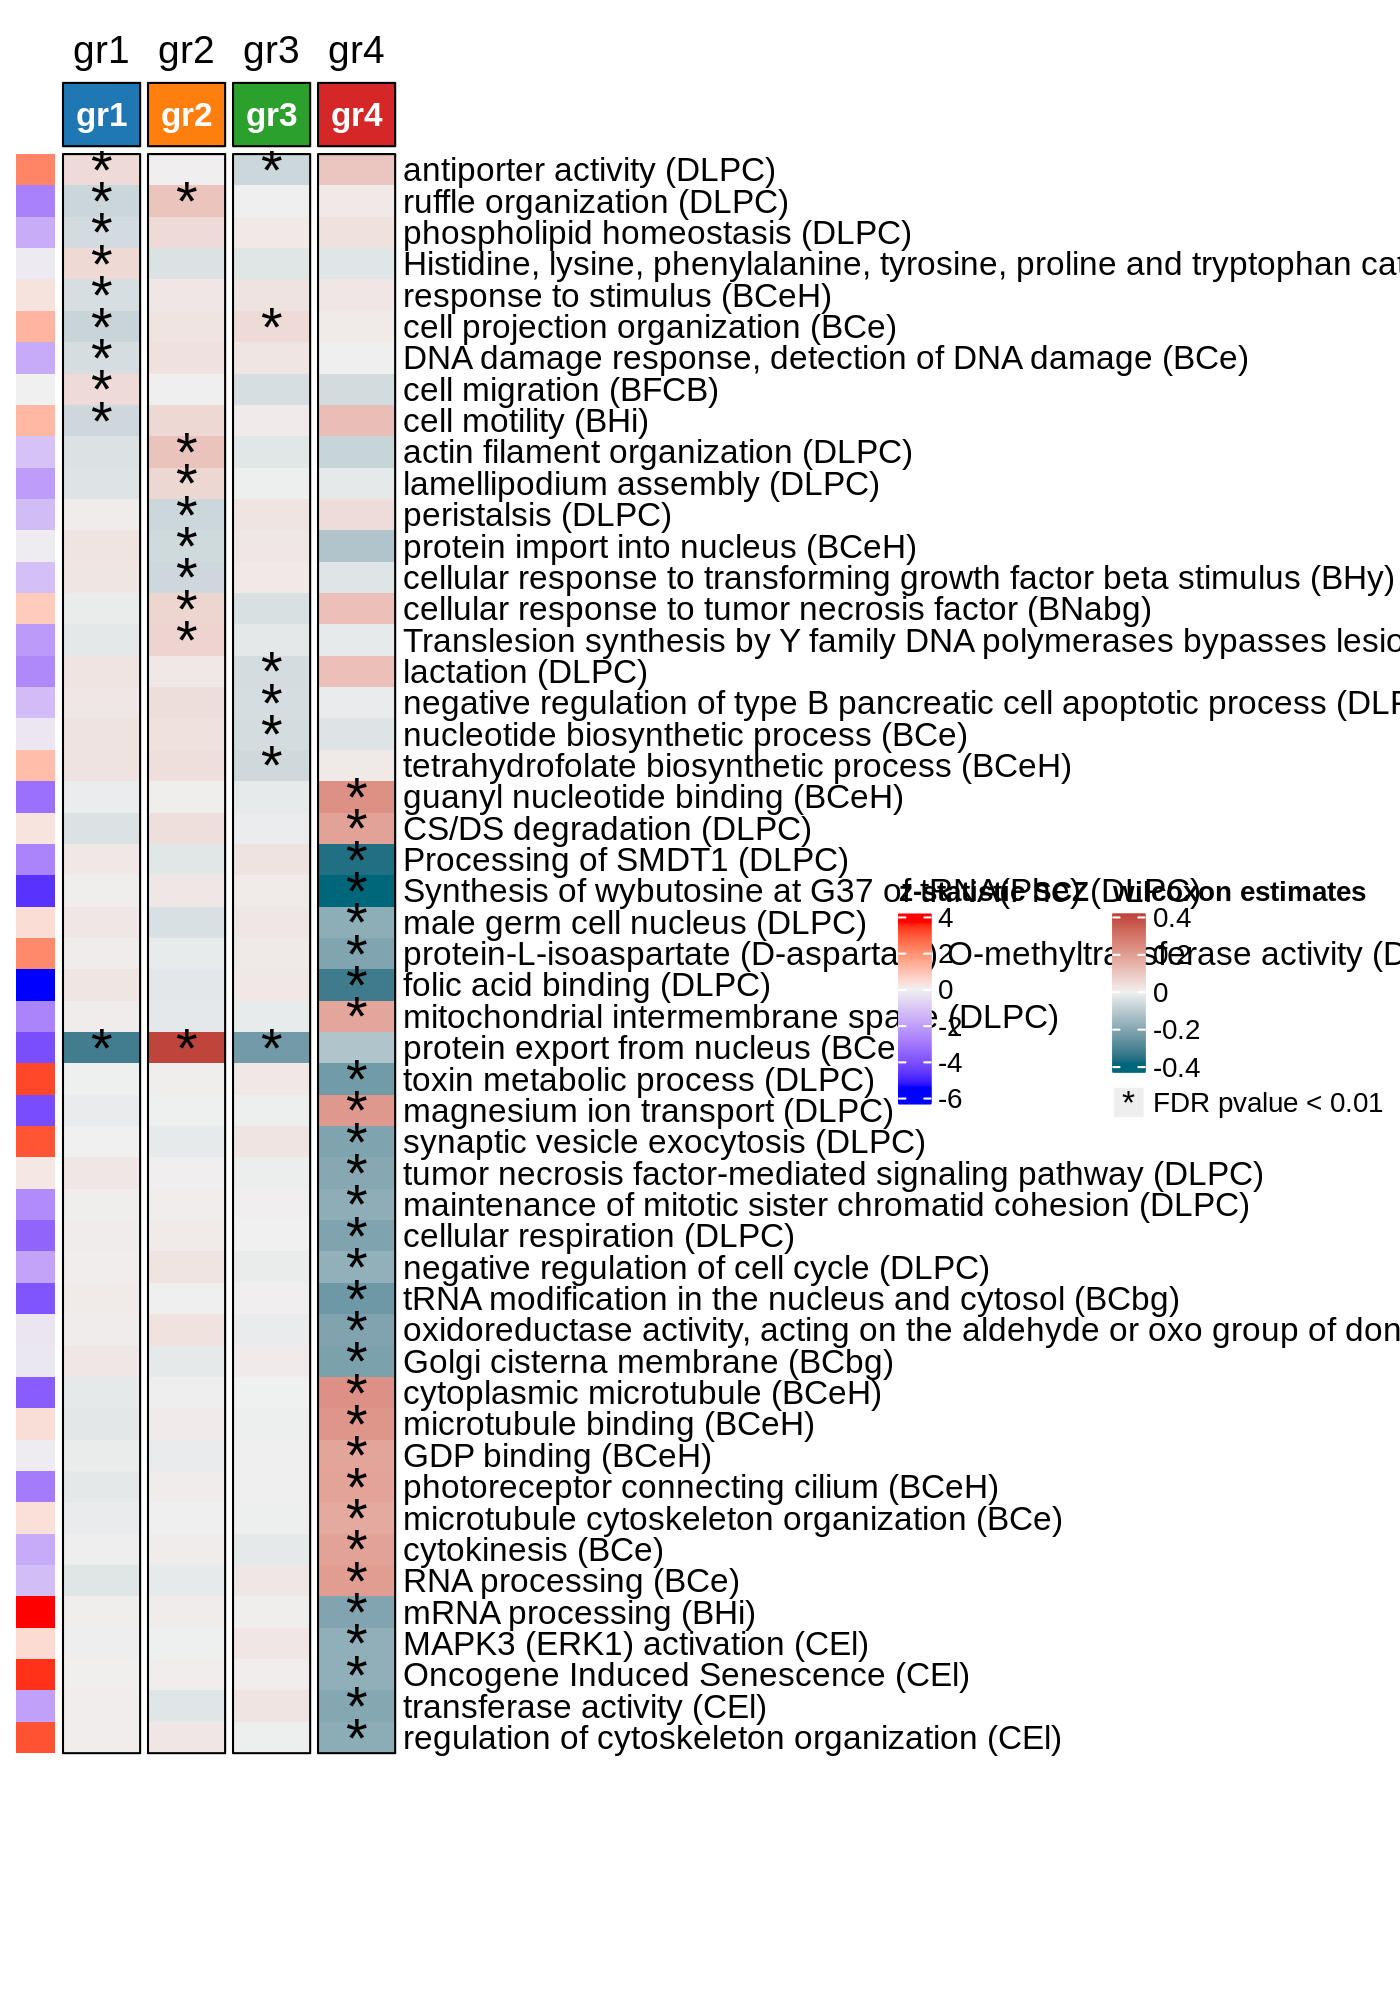

In [56]:
#### heatmap path not in MHC ####

options(repr.plot.width = 7, repr.plot.height = 10, repr.plot.res = 200)
pheno_name <- 'SCZ'
path_anno$id <- paste(path_anno$feat, sapply(path_anno$tissue, get_short_name))
id_keep <- !rownames(feat_est) %in% path_anno$id[path_anno$genes_in_mhc]
P <- length(gr_tot)
# cap
tmp_mat <- as.matrix(feat_est[id_keep, ])
val <- abs(quantile(as.vector(feat_est),probs = 0.95))
mat_breaks <- seq(-val, val, length.out = 100)
tmp_mat[tmp_mat>=val] <- val
tmp_mat[tmp_mat<=-val] <- -val

mat_colors_gr <- list(cluster = pal_d3(palette = 'category20')(P))
names(mat_colors_gr$cluster) <- gr_tot

column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))
feat_pvcorr_pch <- as.matrix(feat_pvcorr[id_keep, ])
feat_pvcorr_pch[feat_pvcorr[id_keep, ] <= pval_corr_thr] <- '*'
feat_pvcorr_pch[feat_pvcorr[id_keep, ] > pval_corr_thr] <- ''

estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
zstat_col_fun = colorRamp2(c(min(res_pval_est[id_keep,12]), 0, max(res_pval_est[id_keep,12])), 
                             c("blue","#F0F0F0", "red"))
row_ha <- rowAnnotation(zstat = res_pval_est[id_keep,12],
                        col = list(zstat = zstat_col_fun), 
                        annotation_label = list(zstat = sprintf('z-statistic %s', pheno_name)), 
                        annotation_name_gp = gpar(col = 'white'))

lgd_est <- Legend(title = "wilcoxon estimates", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("FDR pvalue < %s", as.character(pval_corr_thr)))

hm_pl <- Heatmap(tmp_mat, top_annotation = column_ha, 
                 left_annotation = row_ha,  
                 column_split = gr_tot, 
                 cluster_rows = F, cluster_columns = F, show_column_names = F, 
                 col = estimate_col_fun, border = TRUE, show_heatmap_legend = F, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                           grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 20))})

pdf(sprintf('%sheatmap_cluster_pathNOTMHC_WMWest_%s_%s.pdf', outFold, type_data, type_input),
    width= 7, height = 10)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))
dev.off() 
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))

In [57]:
#### heatmap path in MHC ####
##### TO RUN, SELECT PATHWAYS TO PLOT! #####
options(repr.plot.width = 9,repr.plot.height = 10, repr.plot.res = 200)
pheno_name <- 'SCZ'
id_keep <- rownames(feat_est) %in% path_anno$id[path_anno$genes_in_mhc]
def_mar = 30

show_path <- read.delim('clustering_res_matchUKBB_corrPCs/DLPC_CMC/show_path.txt', h=F, stringsAsFactors = F)
show_path <- show_path$V1
#show_path = 'clathrin-coated pit'
id <- which(res_pval_est$path %in% show_path)

P <- length(gr_tot)
# cap
tmp_mat <- as.matrix(feat_est[id_keep,])
dim(tmp_mat)
val <- abs(quantile(as.vector(feat_est),probs = 0.95))
mat_breaks <- seq(-val, val, length.out = 100)
tmp_mat[tmp_mat>=val] <- val
tmp_mat[tmp_mat<=-val] <- -val

mat_colors_gr <- list(cluster = pal_d3(palette = 'category20')(P))
names(mat_colors_gr$cluster) <- gr_tot

column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))
feat_pvcorr_pch <- feat_pvcorr[id_keep,]
feat_pvcorr_pch[feat_pvcorr[id_keep,] <= pval_corr_thr] <- '*'
feat_pvcorr_pch[feat_pvcorr[id_keep,] > pval_corr_thr] <- ''

estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
zstat_col_fun = colorRamp2(c(min(res_pval_est[,12]), 0, max(res_pval_est[,12])), 
                             c("blue","#F0F0F0", "red"))

row_ha <- rowAnnotation(zstat = res_pval_est[id_keep,12],
                        col = list(zstat = zstat_col_fun),
                        annotation_label = list(zstat = sprintf('z-statistic %s', pheno_name)), 
                        annotation_name_gp = gpar(col = 'white'))

row_ha_names <- rowAnnotation(foo = anno_mark(at = id, 
                                              labels = res_pval_est$new_id[id])) 
                             

lgd_est <- Legend(title = "wilcoxon estimates", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("FDR pvalue < %s", as.character(pval_corr_thr)))

hm_pl <- Heatmap(tmp_mat, top_annotation = column_ha, 
                 left_annotation = row_ha,  
                 right_annotation = row_ha_names, 
                 #row_km = 9,
                 column_split = gr_tot, 
                 cluster_rows = T, cluster_columns = F, 
                 show_column_names = F, show_row_names = F, 
                 show_row_dend=F, 
                 col = estimate_col_fun, border = TRUE, show_heatmap_legend = F, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                           grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 8))})

side_par <- round(max(sapply(rownames(tmp_mat), nchar))) + 30
pdf(sprintf('%sheatmap_cluster_pathwayinMHC_WMWest_%s_%s.pdf', outFold, type_data, type_input), width= 9, height = 10)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) #padding = unit(c(2,def_mar + side_par , 2, 2), "mm"))
dev.off() 
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
#    padding = unit(c(2, def_mar + side_par, 2, 2), "mm"))

Warning message in file(file, "rt"):
“cannot open file 'clustering_res_matchUKBB_corrPCs/DLPC_CMC/show_path.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [66]:
# load wiki and CMC gene set results (probabily repeated)

fold_PALAS <- 'Meta_Analysis_SCZ/OUTPUT_all/'
pathWiki <- read.delim(sprintf('%scustomPath_WikiPath2019Human_pval_SCZ_covCorr_filt.txt', fold_PALAS), h=T, stringsAsFactors = F, sep = '\t')
pathCMC <- read.delim(sprintf('%scustomPath_CMC_GeneSets_pval_SCZ_covCorr_filt.txt', fold_PALAS), h=T, stringsAsFactors = F, sep = '\t')

pathWiki <- pathWiki %>% 
    select(path, ngenes_tscore, ngenes_path, genes_path, tissue) %>%
    mutate(coverage = ngenes_tscore/ngenes_path, name = "WikiPathways") %>%
    rename(gene_name = genes_path)

pathCMC <- pathCMC %>% 
    select(path, ngenes_tscore, ngenes_path, genes_path, tissue) %>%
    mutate(coverage = ngenes_tscore/ngenes_path, name = "CMC GeneSets") %>%
    rename(gene_name = genes_path)

pathWiki_anno <- list()
pathway_feat_wiki_tot <- do.call(rbind, pathway_feat_wiki$test_feat)

for(idg in 1:length(gr_tot)){

    gr <- paste0(gr_tot[idg], '_vs_all')
    print(gr)
    tmp <- list()
    for(idt in 1:length(tissues_name)){
        t <- tissues_name[idt]
        pathway_struct <- pathWiki[pathWiki$tissue == t,]
        tmp[[idt]] <- get_improvement(pathway_feat_wiki_tot, tscore_test, gr, t, pathway_struct)
    }
    pathWiki_anno[[idg]] <- do.call(rbind, tmp)
}
pathWiki_anno <- do.call(rbind, pathWiki_anno)
pathWiki_anno$genes_in_mhc <- NA
for(i in 1:nrow(pathWiki_anno)){

    genes <- strsplit(pathWiki_anno$genes[i], split = ',')[[1]]
    t <- pathWiki_anno$tissue[i]
    tmp <- geneInfo[geneInfo$external_gene_name %in% genes, ]
    tmp <- tmp[!duplicated(tmp$ensembl_gene_id), ]
    pathWiki_anno$genes_in_mhc[i] <- F
    if(any(tmp$chrom == 'chr6' & tmp$start_position >= 26000000 & tmp$end_position <= 34000000)){
        pathWiki_anno$genes_in_mhc[i] <- T
    }
}

pathCMCset_anno <- list()
pathway_feat_CMCset_tot <- do.call(rbind, pathway_feat_CMCset$test_feat)

for(idg in 1:length(gr_tot)){

    gr <- paste0(gr_tot[idg], '_vs_all')
    print(gr)
    tmp <- list()
    for(idt in 1:length(c("DLPC_CMC"))){
        t <- tissues_name[idt]
        pathway_struct <- pathCMC[pathCMC$tissue == t,]
        tmp[[idt]] <- get_improvement(pathway_feat_CMCset_tot, tscore_test, gr, t, pathway_struct)
    }
    pathCMCset_anno[[idg]] <- do.call(rbind, tmp)
}
pathCMCset_anno <- do.call(rbind, pathCMCset_anno)
pathCMCset_anno$genes_in_mhc <- NA
for(i in 1:nrow(pathCMCset_anno)){

    genes <- strsplit(pathCMCset_anno$genes[i], split = ',')[[1]]
    t <- pathCMCset_anno$tissue[i]
    tmp <- geneInfo[geneInfo$external_gene_name %in% genes, ]
    tmp <- tmp[!duplicated(tmp$ensembl_gene_id), ]
    pathCMCset_anno$genes_in_mhc[i] <- F
    if(any(tmp$chrom == 'chr6' & tmp$start_position >= 26000000 & tmp$end_position <= 34000000)){
        pathCMCset_anno$genes_in_mhc[i] <- T
    }
}

path_anno_combined <- rbind(pathWiki_anno, pathCMCset_anno)


[1] "gr1_vs_all"
[1] "gr2_vs_all"
[1] "gr3_vs_all"
[1] "gr4_vs_all"
[1] "gr1_vs_all"
[1] "gr2_vs_all"
[1] "gr3_vs_all"
[1] "gr4_vs_all"


In [69]:
# get pathway sign and create matrix
#### TO RUN: could be modified extra_pathway_list #####


extra_pathway_list <- c("Cytokines and Inflammatory Response WP530",
                        "Complement Activation WP545",
                        "Insulin Signaling WP481",
                        "MO:PresynapticCompartmentProteins_Morciano",
                        "Neuronal proteome:PSD",
                        "MouseMeta:green_M5_Mitochondria",
                        "CTX:green_M10_GlutamatergicSynapticFunction",
                        "Insulin Signaling WP481",
                        "MO:Endoplasmic_Reticulum_Foster",
                        "MO:Plasma_membrane_Foster",
                        "Oxidative Damage WP3941",
                        "Type II interferon signaling (IFNG) WP619", 
                        "GWAS:PGC2 SCZ")

path_anno_extra <- path_anno_combined[path_anno_combined$feat %in% extra_pathway_list,]
path_anno_extra <- path_anno_extra[path_anno_extra$ngenes > 1,]
tot_combined <- rbind(pathway_feat_wiki_tot, pathway_feat_CMCset_tot)
path_unique <- unique(path_anno_extra$feat)
N_path <- length(unique(path_anno_extra$feat))

feat_est_extra <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_CIl_extra <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_CIu_extra <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_pvcorr_extra <- matrix(NA, nrow = N_path ,ncol = length(gr_tot))
new_name <- vector(mode = 'numeric', length = N_path)

for(i in 1:N_path){
# i=269
path <- path_unique[i]
tmp <- tot_combined %>% filter(feat %in% path)
tmp <- tmp %>% filter(pval_corr <= pval_corr_thr)
tmp <- tmp[paste0(tmp$feat, tmp$tissue) %in% paste0(path_anno_extra$feat, path_anno_extra$tissue),]    
top_t <- tmp[order(tmp$pval), ]
top_t <- tmp[order(abs(tmp$estimates), decreasing = T),]

t <- top_t$tissue[1]
short <- get_short_name(t)
new_name[i] <- paste(path, short)

feat_est_extra[i,] <- tot_combined$estimates[tot_combined$tissue == t & tot_combined$feat == path]
feat_CIl_extra[i,] <- tot_combined$CI_low[tot_combined$tissue == t & tot_combined$feat == path]
feat_CIu_extra[i,] <- tot_combined$CI_up[tot_combined$tissue == t & tot_combined$feat == path]
feat_pvcorr_extra[i,] <- tot_combined$pval_corr[tot_combined$tissue == t & tot_combined$feat == path]

}

rownames(feat_est_extra) <- rownames(feat_CIl_extra) <- rownames(feat_CIu_extra) <- rownames(feat_pvcorr_extra) <- new_name
colnames(feat_est_extra) <- colnames(feat_CIl_extra) <- colnames(feat_CIu_extra) <- colnames(feat_pvcorr_extra) <- gr_tot

res_pval_path_extra <- do.call(rbind, list(do.call(rbind, pathway_feat_wiki$res_pval), pathway_feat_CMCset$res_pval[[1]]))
res_pval_path_extra <- left_join(res_pval_path_extra, df_match) %>%
    mutate(new_id = paste(path, short))
res_pval_est_extra <- res_pval_path_extra[match(new_name, res_pval_path_extra$new_id), ]
res_pval_est_extra

Joining, by = "tissue"



,path,ngenes_tscore,ngenes_path,mean_dev_geno,sd_dev_geno,mean_test_dev_geno,sd_test_dev_geno,mean_gene_corr,sd_gene_corr,Dx_beta,⋯,Dx_z,Dx_pval,Dx_qval,Dx_pval_BHcorr,Dx_Cochran_stat,Dx_Cochran_pval,Dx_model,tissue,short,new_id
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
725,Complement Activation WP545,2,22,0.3368024,0.22136384,0.19721372,0.25690359,-2.220472e-01,NA,0.10590626,⋯,7.2726508,3.525007e-13,8.314148e-11,1.212602e-10,38.90560,0.29820464,fixed,Brain_Cerebellar_Hemisphere,(BCeH),Complement Activation WP545 (BCeH)
1015,Cytokines and Inflammatory Response WP530,2,26,0.4215089,0.14205895,0.28124645,0.23512399,1.388843e-04,NA,0.03667367,⋯,2.9096221,3.618660e-03,8.549814e-02,1.057762e-01,50.58608,0.04283377,fixed,Brain_Cerebellum,(BCe),Cytokines and Inflammatory Response WP530 (BCe)
189,Insulin Signaling WP481,48,160,0.1008405,0.06829287,0.04481184,0.05316563,1.088543e-03,0.03979991,0.18015851,⋯,2.9713014,2.965406e-03,3.109362e-02,3.550683e-02,55.61996,0.01477659,fixed,DLPC_CMC,(DLPC),Insulin Signaling WP481 (DLPC)
2509,Oxidative Damage WP3941,4,40,0.1660876,0.11593558,0.07703639,0.10352710,4.789446e-03,0.04081609,-0.12582007,⋯,-7.0524867,1.757483e-12,3.340526e-10,5.395471e-10,56.41877,0.01234817,fixed,Cells_EBV-transformed_lymphocytes,(CEl),Oxidative Damage WP3941 (CEl)
2581,Type II interferon signaling (IFNG) WP619,2,37,0.3569767,0.31861008,0.17680680,0.23583535,4.497049e-02,NA,-0.05932015,⋯,-4.7673822,1.866350e-06,4.434320e-05,7.162120e-05,55.44898,0.01534992,fixed,Cells_EBV-transformed_lymphocytes,(CEl),Type II interferon signaling (IFNG) WP619 (CEl)
2604,CTX:green_M10_GlutamatergicSynapticFunction,107,484,0.1228208,0.09343168,0.06697685,0.08232244,2.857756e-04,0.03587390,0.08702195,⋯,0.9549674,3.395942e-01,2.728155e-01,6.198126e-01,30.30250,0.69428561,fixed,DLPC_CMC,(DLPC),CTX:green_M10_GlutamatergicSynapticFunction (DLPC)
2622,GWAS:PGC2 SCZ,109,414,0.1546533,0.12750727,0.09316089,0.11887354,2.667149e-03,0.09208034,-0.08506637,⋯,-1.0408711,2.979354e-01,2.697429e-01,6.128321e-01,34.23824,0.50470086,fixed,DLPC_CMC,(DLPC),GWAS:PGC2 SCZ (DLPC)
2811,MO:Endoplasmic_Reticulum_Foster,42,122,0.1783990,0.15529465,0.11874624,0.15454462,2.270936e-04,0.03415958,-0.15267729,⋯,-2.6507553,8.031201e-03,5.060627e-02,1.149730e-01,37.64909,0.34890659,fixed,DLPC_CMC,(DLPC),MO:Endoplasmic_Reticulum_Foster (DLPC)
2817,MO:Plasma_membrane_Foster,44,143,0.1605623,0.15350974,0.09710148,0.15284498,-3.794927e-04,0.03392342,0.01190675,⋯,0.2008709,8.407995e-01,4.010479e-01,9.111453e-01,31.83892,0.62150430,fixed,DLPC_CMC,(DLPC),MO:Plasma_membrane_Foster (DLPC)


png 
  2

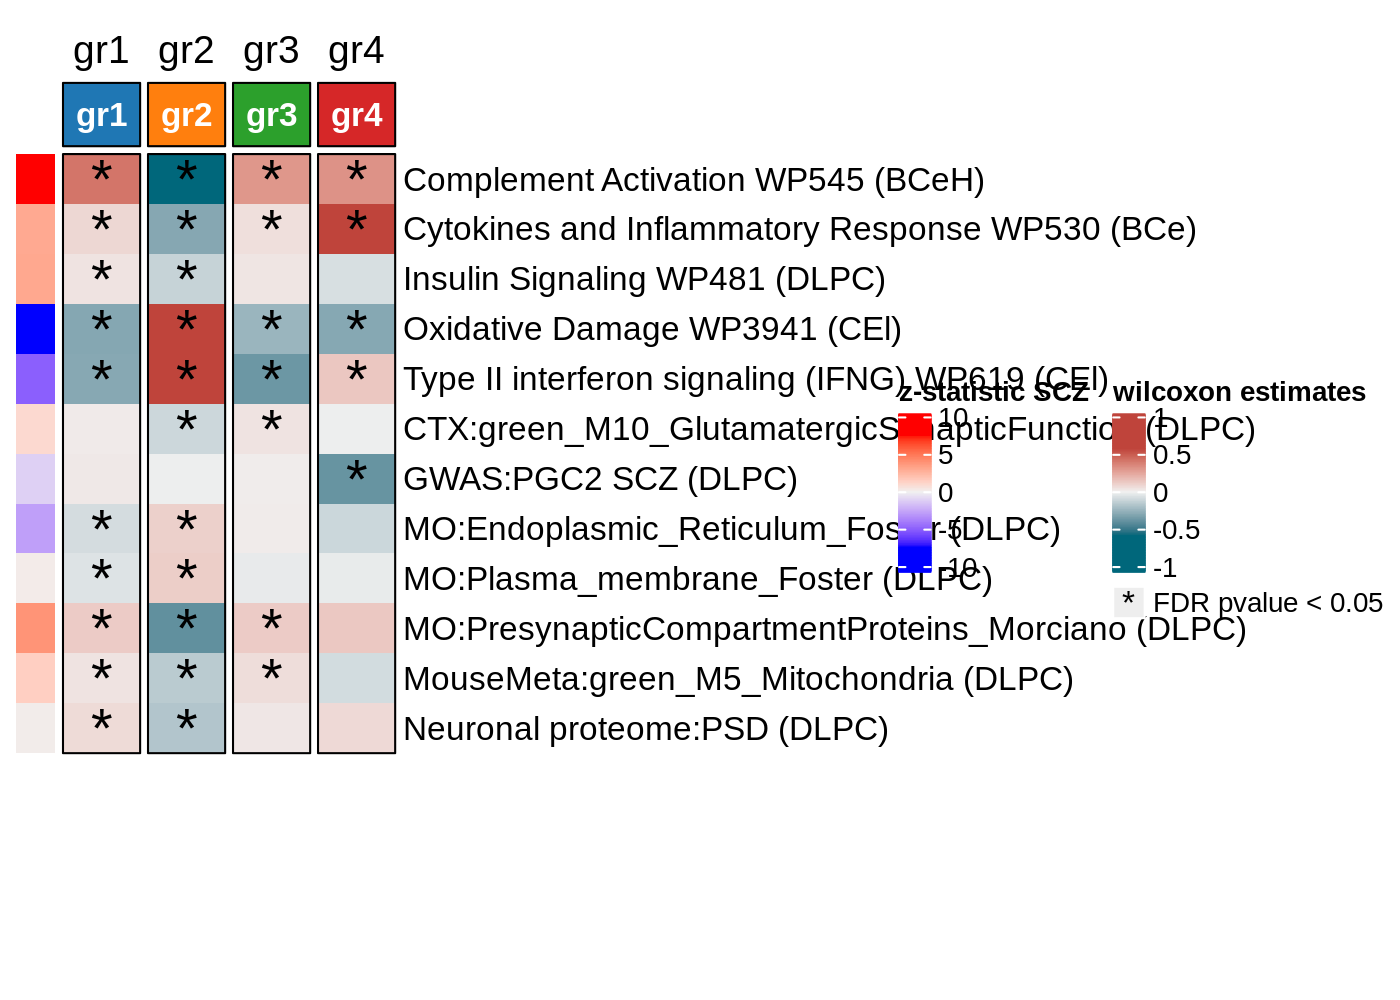

In [70]:
#### heatmap path extracted ####

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
pheno_name <- 'SCZ'
path_anno_combined$id <- paste(path_anno_combined$feat, sapply(path_anno_combined$tissue, get_short_name))

P <- length(gr_tot)
# cap
tmp_mat <- as.matrix(feat_est_extra)
val <- abs(quantile(as.vector(feat_est_extra),probs = 0.95))
mat_breaks <- seq(-val, val, length.out = 100)
tmp_mat[tmp_mat>=val] <- val
tmp_mat[tmp_mat<=-val] <- -val

mat_colors_gr <- list(cluster = pal_d3(palette = 'category20')(P))
names(mat_colors_gr$cluster) <- gr_tot

column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))
feat_pvcorr_pch <- as.matrix(feat_pvcorr_extra[, ])
feat_pvcorr_pch[feat_pvcorr_extra[, ] <= 0.05] <- '*'
feat_pvcorr_pch[feat_pvcorr_extra[, ] > 0.05] <- ''

estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
zstat_col_fun = colorRamp2(c(min(res_pval_est_extra[,12]), 0, max(res_pval_est_extra[,12])), 
                             c("blue","#F0F0F0", "red"))
row_ha <- rowAnnotation(zstat = res_pval_est_extra[,12],
                        col = list(zstat = zstat_col_fun), 
                        annotation_label = list(zstat = sprintf('z-statistic %s', pheno_name)), 
                        annotation_name_gp = gpar(col = 'white'))

lgd_est <- Legend(title = "wilcoxon estimates", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("FDR pvalue < %s", as.character(0.05)))

hm_pl <- Heatmap(tmp_mat, top_annotation = column_ha, 
                 left_annotation = row_ha,  
                 column_split = gr_tot, 
                 cluster_rows = F, cluster_columns = F, show_column_names = F, 
                 col = estimate_col_fun, border = TRUE, show_heatmap_legend = F, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                           grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 20))})

pdf(sprintf('%sheatmap_cluster_pathextralist_WMWest_%s_%s.pdf', outFold, type_data, type_input),
    width= 7, height = 5)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))
dev.off() 
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))


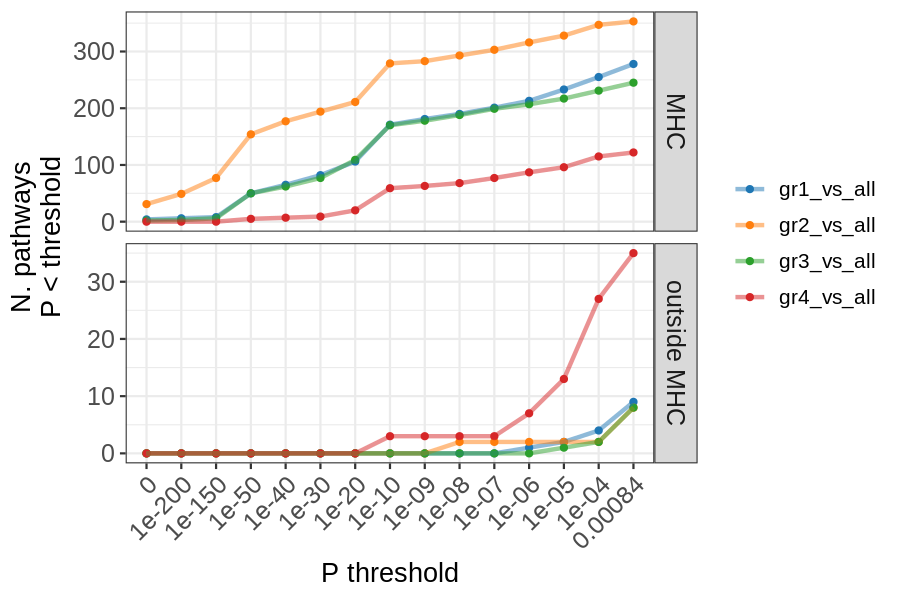

In [71]:
# number of pathways per cluster

options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 150)

path_anno$id_new <- paste0(path_anno$feat,'_',path_anno$tissue, '_', path_anno$comp)

path_sign <- tot[tot$pval_corr <= pval_corr_thr, ]
path_sign <- path_sign %>%    
    dplyr::mutate(id_new = paste0(feat,'_',tissue, '_', comp)) %>%
    dplyr::filter(id_new %in% path_anno$id_new) %>%
    dplyr::mutate(class = dplyr::case_when(id_new %in% path_anno$id_new[!path_anno$genes_in_mhc] ~ 'outside MHC', 
                                           id_new %in% path_anno$id_new[path_anno$genes_in_mhc] ~ 'MHC'))
path_sign$class <- factor(path_sign$class, levels = c('MHC', 'outside MHC'))

thr_values <- c(0, 1e-200, 1e-150, 1e-50, 1e-40,1e-30, 1e-20,  
         1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, max(path_sign$pval))
tmp1 <- unlist(lapply(thr_values, function(x) 
              lapply(comp, function(y) sum(path_sign$pval <= x & path_sign$comp == y & path_sign$class == 'outside MHC'))))
tmp2 <- unlist(lapply(thr_values, function(x) 
              lapply(comp, function(y) sum(path_sign$pval <= x & path_sign$comp == y & path_sign$class == 'MHC'))))
count_thr_pval <- data.frame(count = c(tmp1, tmp2), comp = rep(rep(comp, length(thr_values)), 2), 
                             thr = rep(unlist(lapply(thr_values, function(x) rep(x, length(comp)))), 2), 
                              class = c(rep('outside MHC', length(tmp1)), rep('MHC', length(tmp2))))   

count_thr_pval$thr <- factor(as.character(count_thr_pval$thr), 
levels = as.character(thr_values))
count_thr_pval$class <- factor(count_thr_pval$class, levels = c('MHC', 'outside MHC'))

pl <- ggplot(data=count_thr_pval, aes(x=thr, y=count, group = comp, color = comp)) +
      geom_point(size = 1.2, alpha = 1)+
      geom_line(size = 1, alpha = 0.5)+
      facet_wrap(class~., scales = 'free_y',ncol =  1, strip.position="right")+
      xlab('P threshold')+
      ylab('N. pathways\nP < threshold')+
      scale_color_manual(values = color_gr)+
      theme_bw()+theme(legend.position = "right",
                       strip.text = element_text(size = 12),
                       legend.title = element_blank(),
                       legend.text = element_text(size=10),
                       axis.title = element_text(size=13),
                       axis.text = element_text(size=12), axis.text.x = element_text(angle = 45, hjust = 1))
pl
ggsave(filename = sprintf('%spathwayP_FDRthr0.01_count.pdf', outFold), width = 6, height = 4.2,  plot = pl, device = 'pdf')


In [73]:
path_sign[path_sign$class == 'outside MHC' & path_sign$comp == 'gr4_vs_all', ]

,feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,id_new,class
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
248,CS/DS degradation,gr4_vs_all,5.42e-05,0.1828246,0.09449334,0.27162892,2.758178e-03,1.433854e-03,DLPC_CMC,CS/DS degradation_DLPC_CMC_gr4_vs_all,outside MHC
250,Processing of SMDT1,gr4_vs_all,1.70e-13,-0.3453814,-0.43642357,-0.25424772,3.893000e-11,7.985641e-12,DLPC_CMC,Processing of SMDT1_DLPC_CMC_gr4_vs_all,outside MHC
251,Synthesis of wybutosine at G37 of tRNA(Phe),gr4_vs_all,3.13e-16,-0.3672274,-0.45915131,-0.27724418,8.191657e-14,1.603961e-14,DLPC_CMC,Synthesis of wybutosine at G37 of tRNA(Phe)_DLPC_CMC_gr4_vs_all,outside MHC
253,male germ cell nucleus,gr4_vs_all,1.58e-04,-0.1745156,-0.26424173,-0.08446863,7.421949e-03,4.034230e-03,DLPC_CMC,male germ cell nucleus_DLPC_CMC_gr4_vs_all,outside MHC
257,protein-L-isoaspartate (D-aspartate) O-methyltransferase activity,gr4_vs_all,3.56e-05,-0.1961224,-0.28856772,-0.10350145,1.976339e-03,9.591059e-04,DLPC_CMC,protein-L-isoaspartate (D-aspartate) O-methyltransferase activity_DLPC_CMC_gr4_vs_all,outside MHC
258,folic acid binding,gr4_vs_all,3.13e-11,-0.3087964,-0.39905908,-0.21847326,3.822773e-09,1.253368e-09,DLPC_CMC,folic acid binding_DLPC_CMC_gr4_vs_all,outside MHC
259,mitochondrial intermembrane space,gr4_vs_all,1.57e-04,0.1724240,0.08321834,0.26143322,7.421949e-03,4.022713e-03,DLPC_CMC,mitochondrial intermembrane space_DLPC_CMC_gr4_vs_all,outside MHC
262,toxin metabolic process,gr4_vs_all,1.67e-06,-0.2225048,-0.31310213,-0.13148664,1.176708e-04,5.120402e-05,DLPC_CMC,toxin metabolic process_DLPC_CMC_gr4_vs_all,outside MHC
264,magnesium ion transport,gr4_vs_all,3.84e-06,0.2061120,0.11892727,0.29340774,2.512457e-04,1.134658e-04,DLPC_CMC,magnesium ion transport_DLPC_CMC_gr4_vs_all,outside MHC


**Endophenotype analysis based on gene-RS differences**

In [107]:
# get thr:
precision_file <- '/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/CAD_HARD_clustering/update_corrPCs/cp_metaAnalysis_riskScores_clusterCases_group_relatedPheno_npheno_and_precision.txt'
precision <- read.table(precision_file, h=T, sep = '\t', stringsAsFactors = F) %>%
    filter(tissue == "All tissues")
id <- which.min(precision$thr_measure[precision$precision > 0.9])
precision[precision$precision > 0.9, ][id,]
measureGoodness_thr <- round(precision$thr_measure[precision$precision > 0.9][id])
measureGoodness_thr

id <- which.min(precision$thr_measure[precision$precision > 0.8])
precision[precision$precision > 0.8, ][id,]
measureGoodness_thr_2 <- round(precision$thr_measure[precision$precision > 0.8][id])
measureGoodness_thr_2

,tissue,n_pheno_thr,n_same_sign,precision,recall,thr_measure
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
38,All tissues,993,3466,0.9013092,0.2582227,743.7789


[1] 744

,tissue,n_pheno_thr,n_same_sign,precision,recall,thr_measure
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
12,All tissues,2346,3466,0.8098892,0.5481823,250.0116


[1] 250

In [100]:
setwd('/psycl/g/mpsziller/lucia/')

pheno_name <- 'SCZ'
color_pheno_file <- 'UKBB/eQTL_PROJECT/INPUT_DATA/Covariates/color_pheno_type_UKBB_v2.txt'
riskScore_ann_file <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB_corrPCs/DLPC_CMC/matchUKBB_riskScores_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_annotated.txt'
phenoInfo_file <- 'SCZ_PGC/eQTL_PROJECT/phenotypeDescription_rsSCZ_updated.txt'
# pheno_plot <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/SCZ_clustering/list_phenoid_plot'

pheno_ann <- read.delim(color_pheno_file, header = T, stringsAsFactors = F, sep = '\t')
phenoInfo <- read.delim(phenoInfo_file, header = T, stringsAsFactors = F, sep = '\t')
if(!'pheno_type' %in% colnames(phenoInfo)){
  tmp_name <- sapply(phenoInfo$Path, function(x) strsplit(x, split = '> ')[[1]][length(strsplit(x, split = '> ')[[1]])])
  tmp_name <- sapply(tmp_name, function(x) paste0(strsplit(x, split = ' ')[[1]], collapse = '_'))
  phenoInfo$pheno_type <- tmp_name
  phenoInfo$pheno_type[phenoInfo$pheno_type == 'Summary_Information_(diagnoses)'] <- 'ICD9-10_OPCS4'
}

cov_id <- clust_res$test_cov$cov_id[-nrow(clust_res$test_cov)]

phenoInfo_summary <- phenoInfo %>%
    group_by(pheno_type) %>%
    summarise(N=n(), pheno_id = paste0(pheno_id, collapse = ','), 
              Covariates =  paste0(cov_id, collapse = ','))
# phenoInfo_summary
write.table(sprintf('%sendophenotype_tested_class.txt', outFold), x = phenoInfo_summary, sep = '\t', col.names = T, row.names = F)

rs_res <- read.delim(riskScore_ann_file, h=T, stringsAsFactors = F, sep = '\t')
rs_res <- rs_res[!is.na(rs_res$pvalue), ]
head(rs_res[order(rs_res$measure, decreasing = T),])

,pheno_id,Field,meaning,beta,se_beta,z,pvalue,OR_or_Beta,CI_low,CI_up,type_pheno,pval_corr,comp,pval_corr_overall,R2_risk,Fstat_risk,measure,pheno_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1015,30000,White blood cell (leukocyte) count,NA,-0.5020261,0.01647525,-30.47152,6.263509e-200,-0.5020261,-0.5343170,-0.4697352,CONTINUOUS,6.263509e-197,gr2_vs_all,2.222641e-195,0.04177776,14464.15,7261.382,Blood_count
1027,30120,Lymphocyte count,NA,-0.4698558,0.01651689,-28.44700,5.985259e-175,-0.4698558,-0.5022283,-0.4374833,CONTINUOUS,2.992629e-172,gr2_vs_all,1.061951e-170,0.04058922,14167.57,6656.713,Blood_count
1860,30860,Total protein,NA,-0.4631094,0.01652411,-28.02628,5.866654e-170,-0.4631094,-0.4954960,-0.4307227,CONTINUOUS,1.955551e-167,gr2_vs_all,6.939384e-166,0.03588929,11124.33,5151.783,Blood_biochemistry
1029,30140,Neutrophill count,NA,-0.3827194,0.01661489,-23.03473,4.416427e-116,-0.3827194,-0.4152840,-0.3501548,CONTINUOUS,7.360712e-114,gr2_vs_all,2.611990e-112,0.03906450,13457.37,5150.396,Blood_count
1030,30150,Eosinophill count,NA,-0.4047567,0.01659254,-24.39389,9.116323e-130,-0.4047567,-0.4372775,-0.3722359,CONTINUOUS,1.823265e-127,gr2_vs_all,6.469957e-126,0.03510981,12188.90,4933.538,Blood_count
1839,30650,Aspartate aminotransferase,NA,-0.4229093,0.01657282,-25.51824,1.198864e-141,-0.4229093,-0.4553914,-0.3904272,CONTINUOUS,2.997160e-139,gr2_vs_all,1.063559e-137,0.02975328,10866.96,4595.739,Blood_biochemistry


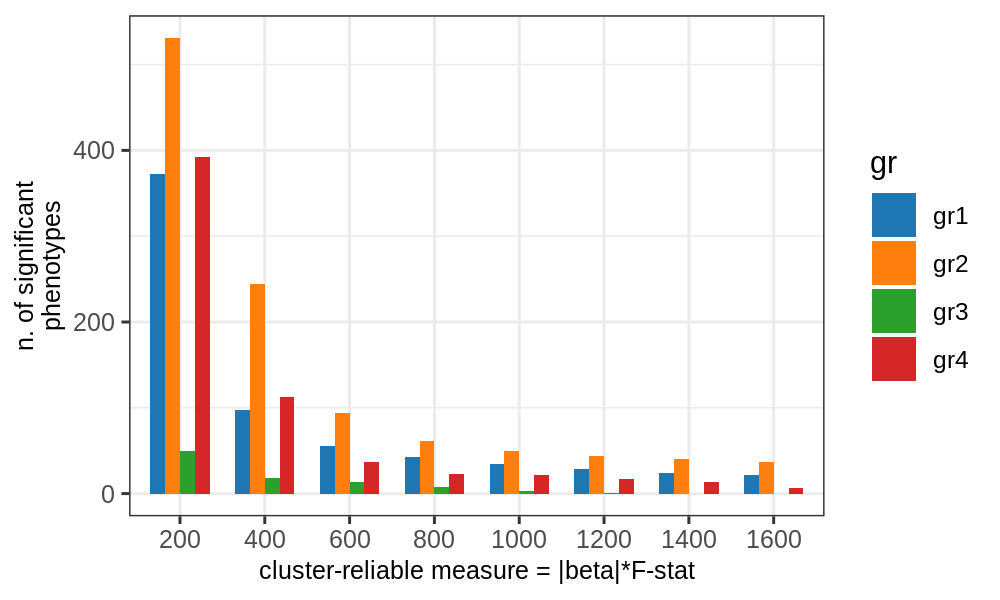

In [101]:
###################################
### plot number of association ####
###################################

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

rs_res$comp <- factor(rs_res$comp)
rs_res$sign <- 'no'
rs_res$sign[rs_res$pval_corr <= 0.05] <- 'yes'

thr_lims <- seq(200, 1600, by = 200)
df <- list()
for(i in 1:length(thr_lims)){
  df[[i]] <- rs_res %>% filter(measure >=thr_lims[i]) %>% group_by(comp) %>% count(sign, .drop = FALSE) %>% add_column(CRM_thr = thr_lims[i])
}
df <- bind_rows(df)
df <- df %>% mutate(gr = strsplit(as.character(comp), split = '_vs_all')[[1]])
df$gr <- factor(df$gr)
df$CRM_thr <- factor(df$CRM_thr, levels = thr_lims)

pl_count <-  ggplot(df, aes(x = CRM_thr, y = n, fill = gr))+
  geom_bar(stat = 'identity', width = 0.7,
           position=position_dodge())+
  theme_bw()+ 
  ylab('n. of significant\nphenotypes')+ 
  xlab('cluster-reliable measure = |beta|*F-stat')+ 
  theme(legend.position = 'right', axis.title.y = element_text(size = 9), axis.title.x = element_text(size=9),
        axis.text.x = element_text(size = 9), axis.text.y = element_text(size = 9))+
  scale_fill_d3()
ggsave(filename = sprintf('%sriskScores_tscore_zscaled_cluster%sDLPC_GLM_count.pdf', outFold, 'Cases'), width = 5, height = 3, plot = pl_count, device = 'pdf')

pl_count

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


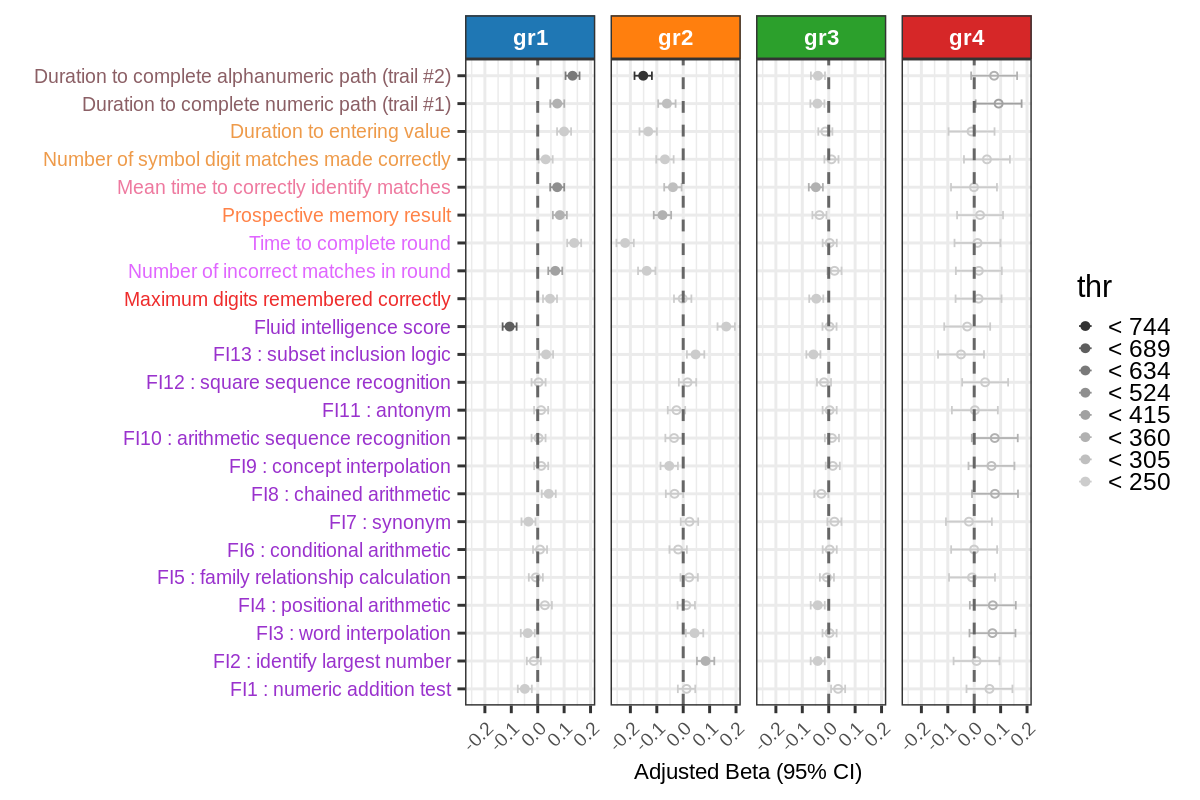

In [105]:
####################################
##### plot cognitive functions #####
####################################
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)

P <- length(unique(rs_res$comp))
labs_new <- sapply(as.character(unique(rs_res$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
names(labs_new) <- as.character(unique(rs_res$comp))
gr_color <- pal_d3(palette = 'category20')(P)
                   
id_FI <- as.character(c(486, 4935 ,4946 ,4957, 4968, 4979,4990,5001,5012,5556,5699,5779,5790,5866,20016))
id_PaM <- as.character(c('399', '400'))
id_NM <- as.character(c('20240'))
id_RT <- as.character(c('20023'))
id_PM <- as.character(c('20018'))
id_SDS <- as.character(c('20230', '20159'))
id_TM <- as.character(c('20156', '20157'))

rs_red <- rs_res[rs_res$pheno_id %in% c(id_FI, id_TM, id_SDS, id_PM, id_RT, id_NM, id_PaM), ]

df_red <- rs_red
df_red$type_m <- 'not reliable'
df_red$type_m[df_red$measure >= measureGoodness_thr] <- 'reliable'
df_red$new_id <- df_red$Field
df_red$new_id[!is.na(df_red$meaning)] <- paste(df_red$meaning[!is.na(df_red$meaning)], df_red$Field[!is.na(df_red$meaning)], sep = '\n')
df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
df_red$type_m <- factor(df_red$type_m, levels = c('not reliable', 'reliable'))
df_red$type_res <- 'beta'
df_red$sign <- 'no'
df_red$sign[df_red$pval_corr <= 0.05] <- 'yes'
df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
thr_lims <- round(seq(measureGoodness_thr_2, measureGoodness_thr, length.out = 10))
df_red$thr <- paste0('< ', thr_lims[1])
for(i in 1:(length(thr_lims)-1)){
  df_red$thr[df_red$measure > thr_lims[i] & df_red$measure <= thr_lims[i+1]] <- paste0('< ', thr_lims[i+1])
}
thr_lims <- unique(df_red$thr)
thr_lims <- thr_lims[order(as.numeric(sapply(thr_lims, function(x) strsplit(x, split = '< ')[[1]][2])))]
df_red$thr <- factor(df_red$thr, levels = rev(thr_lims))
pheno_ann_red <- pheno_ann[match(df_red$pheno_type, pheno_ann$pheno_type), ]

len_w <- length(unique(df_red$comp))
len_h <- length(unique(df_red$pheno_id))

pl_beta <-  ggplot(df_red, aes(x = new_id, y = OR_or_Beta, shape = sign, color = thr))+
  geom_errorbar(aes(ymin=CI_low, ymax=CI_up), size = 0.3, width=.3, position=position_dodge(0.05), linetype="solid")+
  geom_point(position=position_dodge(0.05), size = 1)+
  theme_bw()+
  ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
  theme(legend.position = 'right', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
        legend.key.size = unit(0.2, "cm"),
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red$color),
        strip.text = element_text(size=8, color = 'white', face = 'bold'))+
  scale_shape_manual(values=c(1, 19))+
  scale_colour_grey()+
  guides(shape = FALSE)+
  coord_flip()

pl_beta <- ggplot_gtable(ggplot_build(pl_beta))
stripr <- which(grepl('strip-t', pl_beta$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
  j <- which(grepl('rect', pl_beta$grobs[[i]]$grobs[[1]]$childrenOrder))
  pl_beta$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
  k <- k+1
}
ggsave(filename = sprintf('%sriskScore_tscore_zscaled_cluster%sDLPC_GLM_beta_CogntiveTests.pdf', outFold,'Cases'), width = len_w+3, height = (len_h)*0.1+1, plot = pl_beta, device = 'pdf')
tot_pl <- ggarrange(plotlist = list(pl_beta), ncol = 1, nrow = 1, align='v')
print(tot_pl)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


[1] 744

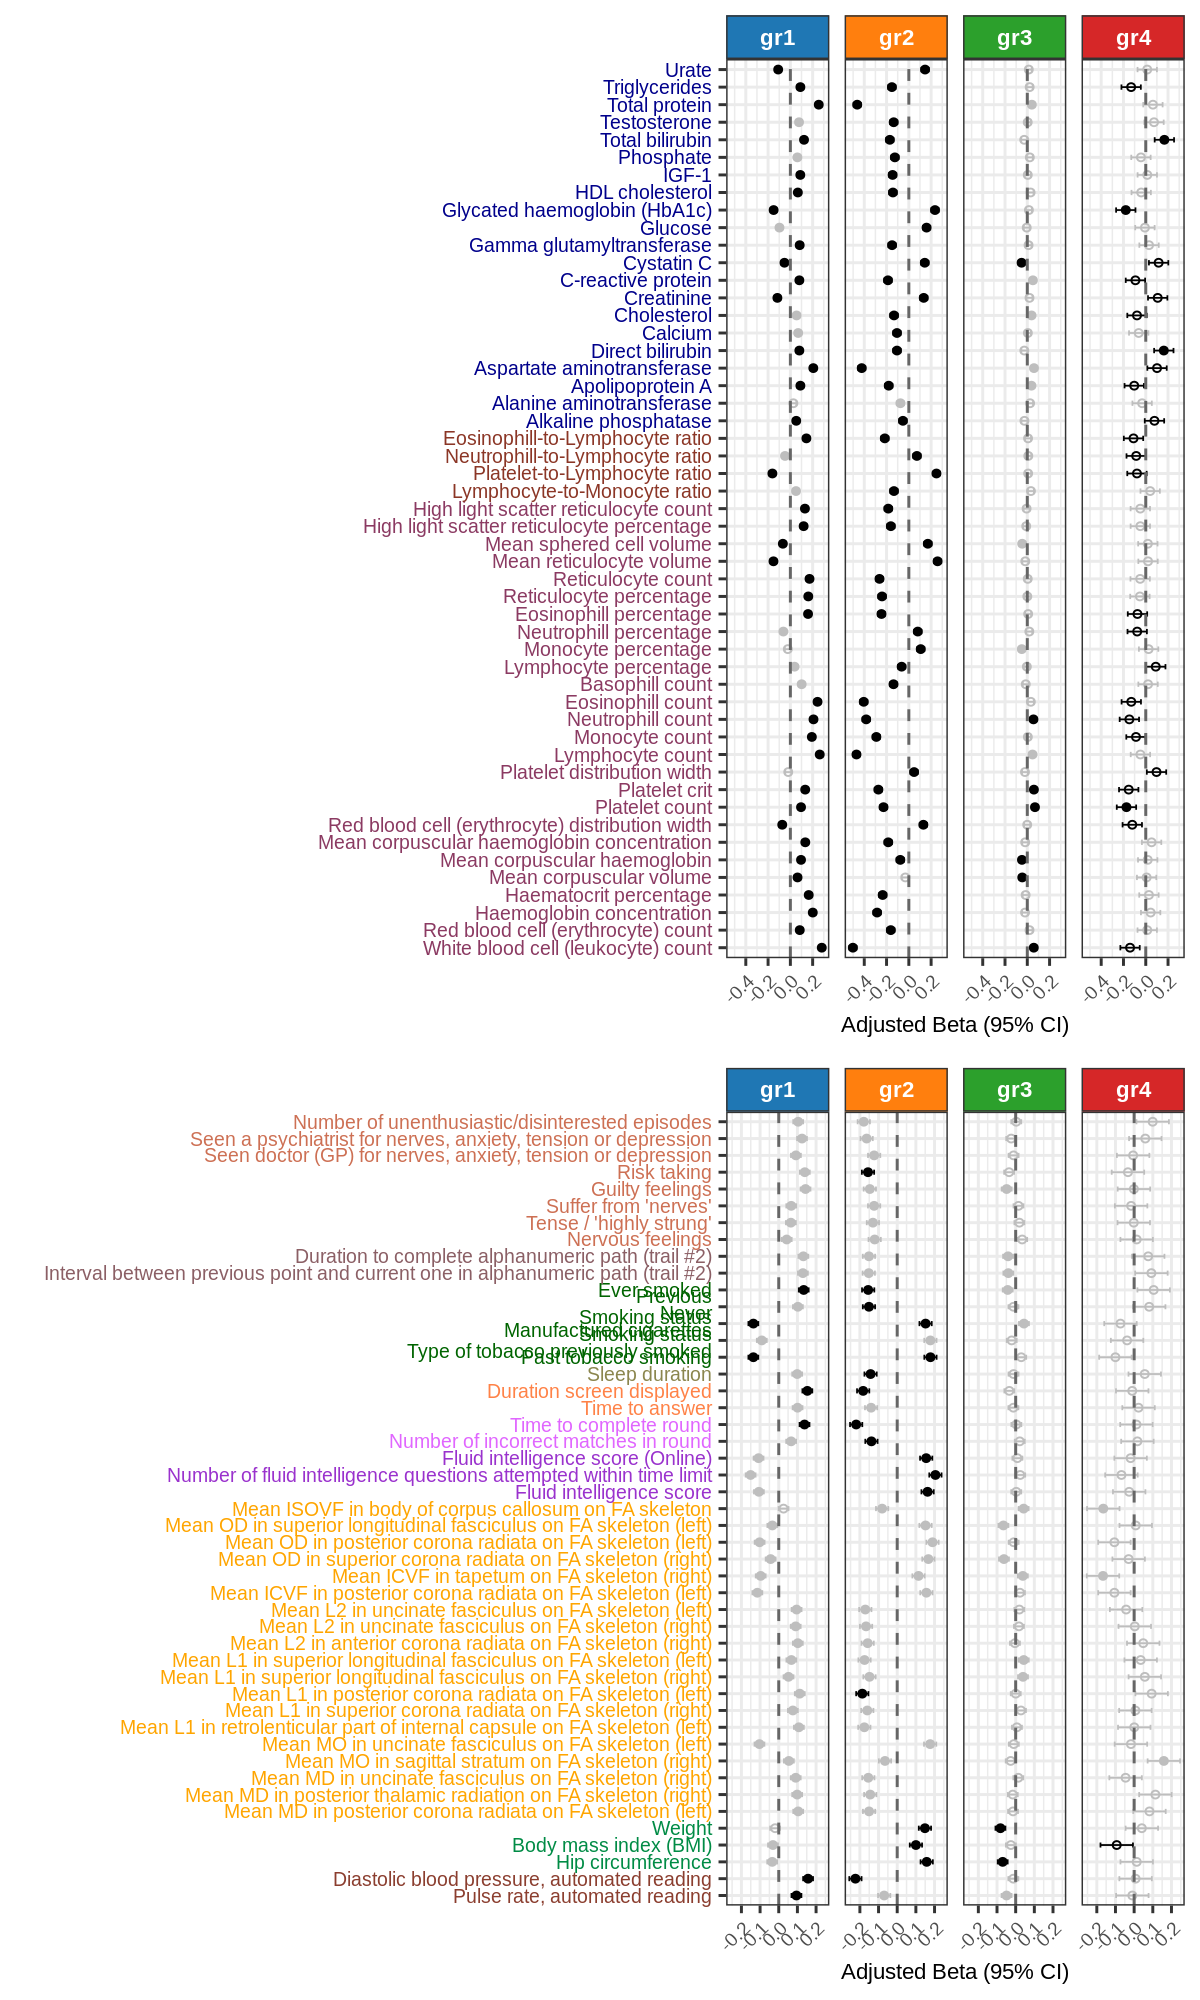

In [112]:
####################################################
### plot selection of association among 610 thr ####
####################################################

forest_plot_geneRS <- function(pheno_keep, rs_res, measureGoodness_thr, outFold, prop_pl = 0.7){  
    
  rs_tmp <- rs_res[rs_res$pheno_id %in% pheno_keep, ]
  rs_tmp$new_id <- paste0(rs_tmp$comp, '_and_', rs_tmp$pheno_id)
  P <- length(unique(rs_tmp$comp))
  gr_color <- pal_d3(palette = 'category20')(P)

df_red <- rs_tmp
df_red$type_m <- 'not reliable'
df_red$type_m[df_red$measure >= measureGoodness_thr] <- 'reliable'
df_red$new_id <- df_red$Field
df_red$new_id[!is.na(df_red$meaning)] <- paste(df_red$meaning[!is.na(df_red$meaning)], 
                                               df_red$Field[!is.na(df_red$meaning)], sep = '\n')
df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
df_red$type_m <- factor(df_red$type_m, levels = c('not reliable', 'reliable'))
df_red$type_res <- 'beta'
df_red$sign <- 'no'
df_red$sign[df_red$pval_corr <= 0.05] <- 'yes'
df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
id <- df_red$type_m == 'reliable' & df_red$sign == 'yes'
table(df_red$pheno_type[id], df_red$comp[id])

# divide in 2 part
df_red1 <- subset(df_red, pheno_type %in% c('Blood_count', 'Blood_biochemistry', 'Blood_count_ratio'))
df_red2 <- subset(df_red, !pheno_type %in% c('Blood_count', 'Blood_biochemistry', 'Blood_count_ratio'))
# df_red2 <- subset(df_red, pheno_type %in% c('dMRI_skeleton'))
pheno_ann_red1 <- pheno_ann[match(df_red1$pheno_type, pheno_ann$pheno_type), ]
pheno_ann_red2 <- pheno_ann[match(df_red2$pheno_type, pheno_ann$pheno_type), ]

len_w <- length(unique(df_red$comp))
len_h <- length(unique(df_red$pheno_id))

# change labels 
labs_new <- sapply(as.character(unique(df_red$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
names(labs_new) <- as.character(unique(df_red$comp))

pl_beta1 <-  ggplot(df_red1, aes(x = new_id, y = OR_or_Beta, shape = sign, color = type_m))+
  geom_errorbar(aes(ymin=CI_low, ymax=CI_up), size = 0.3, width=.3, position=position_dodge(0.05), show.legend=FALSE, linetype="solid")+
  geom_point(position=position_dodge(0.05), size = 1)+
  theme_bw()+ 
  ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
  theme(legend.position = 'none', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red1$color), 
        strip.text = element_text(size=8, color = 'white', face = 'bold'))+
  scale_shape_manual(values=c(1, 19))+
  scale_color_manual(values=c('grey', 'black'))+
  coord_flip()

pl_beta1 <- ggplot_gtable(ggplot_build(pl_beta1))
stripr <- which(grepl('strip-t', pl_beta1$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
  j <- which(grepl('rect', pl_beta1$grobs[[i]]$grobs[[1]]$childrenOrder))
  pl_beta1$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
  k <- k+1
}

pl_beta2 <-  ggplot(df_red2, aes(x = new_id, y = OR_or_Beta, shape = sign, color = type_m))+
  geom_errorbar(aes(ymin=CI_low, ymax=CI_up), size = 0.3, width=.3, position=position_dodge(0.05), show.legend=FALSE, linetype="solid")+
  geom_point(position=position_dodge(0.05), size = 1)+
  theme_bw()+ 
  ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
  theme(legend.position = 'none', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red2$color), 
        strip.text = element_text(size=8, color = 'white', face = 'bold'))+
  scale_shape_manual(values=c(1, 19))+
  scale_color_manual(values=c('grey', 'black'))+
  coord_flip()

pl_beta2 <- ggplot_gtable(ggplot_build(pl_beta2))
stripr <- which(grepl('strip-t', pl_beta2$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
  j <- which(grepl('rect', pl_beta2$grobs[[i]]$grobs[[1]]$childrenOrder))
  pl_beta2$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
  k <- k+1
}

tot_pl <- ggarrange(plotlist = list(pl_beta1, pl_beta2), ncol = 1, nrow = 2, align='v', heights = c(1, prop_pl))
ggsave(filename = sprintf('%sriskScore_tscore_zscaled_cluster%sDLPC_GLM_beta_measureThr%s.pdf', outFold,'Cases', as.character(measureGoodness_thr)), width = len_w+3, height = len_h*0.1+2, plot = tot_pl, device = 'pdf')

return(tot_pl)
}

                   
options(repr.plot.width = 6, repr.plot.height = 10, repr.plot.res = 200)
pheno_keep <- unique(rs_res$pheno_id[rs_res$pval_corr <= 0.05 & rs_res$measure >= 600])
forest_plot_geneRS(pheno_keep, rs_res, measureGoodness_thr, outFold, prop_pl = 0.9)                   

# save table at measureGoodness_thr
pheno_keep <- unique(rs_res$pheno_id[rs_res$pval_corr <= 0.05 & rs_res$measure >= measureGoodness_thr])
rs_tmp <- rs_res[rs_res$pheno_id %in% pheno_keep, ]
write.table(rs_tmp,
            file = sprintf('%sriskScore_tscore_zscaled_cluster%sDLPC_GLM_beta_measureThr%s.txt', outFold,'Cases', as.character(measureGoodness_thr)), 
            col.names = T, row.names = F, sep = '\t', quote = F)    

measureGoodness_thr               

In [118]:
rs_res %>% filter(comp == "gr4_vs_all", pval_corr <= 0.05) %>% arrange(desc(measure))

pheno_id,Field,meaning,beta,se_beta,z,pvalue,OR_or_Beta,CI_low,CI_up,type_pheno,pval_corr,comp,pval_corr_overall,R2_risk,Fstat_risk,measure,pheno_type,sign
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
30080,Platelet count,NA,-0.1731825,0.04436095,-3.903940,9.491119e-05,-0.1731825,-0.26012836,-0.08623664,CONTINUOUS,0.03901787,gr4_vs_all,0.004173453,0.04982942,18639.629,3228.0576,Blood_count,yes
30840,Total bilirubin,NA,0.1670317,0.04436351,3.765068,1.669211e-04,0.1670317,0.08008077,0.25398254,CONTINUOUS,0.03901787,gr4_vs_all,0.007018114,0.04281196,16070.607,2684.3000,Blood_biochemistry,yes
30750,Glycated haemoglobin (HbA1c),NA,-0.1792976,0.04436133,-4.041754,5.322689e-05,-0.1792976,-0.26624417,-0.09235096,CONTINUOUS,0.03901787,gr4_vs_all,0.002481979,0.03677508,13619.633,2441.9670,Blood_biochemistry,yes
30660,Direct bilirubin,NA,0.1620416,0.04436403,3.652544,2.602362e-04,0.1620416,0.07508966,0.24899345,CONTINUOUS,0.04337271,gr4_vs_all,0.010493896,0.03732172,11638.624,1885.9407,Blood_biochemistry,yes
25390,Mean ICVF in tapetum on FA skeleton (right),NA,-0.1668242,0.04436348,-3.760395,1.700684e-04,-0.1668242,-0.25377505,-0.07987340,CONTINUOUS,0.03901787,gr4_vs_all,0.007141981,0.28545511,4236.188,706.6988,dMRI_skeleton,yes
25443,Mean ISOVF in body of corpus callosum on FA skeleton,NA,-0.1652887,0.04436211,-3.725899,1.950893e-04,-0.1652887,-0.25223687,-0.07834061,CONTINUOUS,0.03901787,gr4_vs_all,0.008068595,0.25915603,3932.944,650.0713,dMRI_skeleton,yes
25182,Mean MO in sagittal stratum on FA skeleton (right),NA,0.1592253,0.04436291,3.589154,3.324479e-04,0.1592253,0.07227561,0.24617500,CONTINUOUS,0.04749256,gr4_vs_all,0.013210640,0.28997817,3831.942,610.1421,dMRI_skeleton,yes


In [120]:
length(unique(rs_tmp$pheno_id))
sum(rs_res$pval_corr <= 0.05 & rs_res$measure >= 600)
table(rs_res$comp[rs_res$pval_corr <= 0.05 & rs_res$measure >= 600])

keep_cogn <- c('FI1 : numeric addition test','FI2 : identify largest number', 
               'FI3 : word interpolation', 'FI4 : positional arithmetic', 
               'FI7 : synonym', 'FI6 : conditional arithmetic',
               'FI8 : chained arithmetic', 
               'FI9 : concept interpolation', 
               'FI10 : arithmetic sequence recognition', 
               'FI12 : square sequence recognition', 
               'FI13 : subset inclusion logic', 
               'Fluid intelligence score', 
               'Mean time to correctly identify matches', 
               'Maximum digits remembered correctly',
               'Duration to complete alphanumeric path (trail #2)',
               'Duration to entering value',
               'Prospective memory result', 
               'Time to complete round')

# a = rs_res[rs_res$Field %in% keep_cogn & rs_res$comp == 'gr2_vs_all', ]
a = rs_res[rs_res$pheno_id == 'PLR' & rs_res$comp == 'gr1_vs_all', ]
a[order(a$pvalue),]


[1] 68

[1] 171


gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all 
        56         94         14          7 

,pheno_id,Field,meaning,beta,se_beta,z,pvalue,OR_or_Beta,CI_low,CI_up,type_pheno,pval_corr,comp,pval_corr_overall,R2_risk,Fstat_risk,measure,pheno_type,sign
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
47,PLR,Platelet-to-Lymphocyte ratio,NA,-0.1614442,0.01351046,-11.94957,8.177968e-33,-0.1614442,-0.1879243,-0.1349642,CONTINUOUS,7.434517e-31,gr1_vs_all,9.068744e-30,0.04579225,15968.78,2578.068,Blood_count_ratio,yes


In [123]:
pheno_keep <- unique(rs_res$pheno_id[rs_res$pval_corr <= 0.05 & rs_res$measure >= 600])
rs_tmp <- rs_res[rs_res$pheno_id %in% pheno_keep, ]
length(unique(rs_tmp$pheno_id))
table(rs_tmp$pheno_type[rs_tmp$measure >= measureGoodness_thr & rs_tmp$pval_corr <= 0.05], rs_tmp$comp[rs_tmp$pval_corr <= 0.05 & rs_tmp$measure >= measureGoodness_thr])
length(unique(rs_tmp$pheno_id[rs_tmp$measure >= measureGoodness_thr]))
# rs_tmp[!duplicated(rs_tmp$pheno_id) & !rs_tmp$pheno_type %in% 'Blood_count', c('pheno_id', 'Field', 'pheno_type')]
        

[1] 98

                    
                     gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all
  Blood_biochemistry         15         20          1          3
  Blood_count                21         25          6          1
  Blood_count_ratio           2          4          0          0
  Blood_pressure              2          1          0          0
  Body_size_measures          0          3          2          0
  dMRI_skeleton               0          1          0          0
  Fluid_intelligence          0          3          0          0
  Mental_health               0          1          0          0
  Pairs_matching              1          2          0          0
  Prospective_memory          1          1          0          0
  Sleep                       0          1          0          0
  Smoking                     3          4          0          0

[1] 68

Shown 98 phenotypes (CRM >=600), among which 68 have a CRM > 744 and FDR <= 0.05

In [124]:
### plot for publication ###
#### TO RUN ####
options(repr.plot.width = 6, repr.plot.height = 7.5, repr.plot.res = 200)
pheno_plot <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB_corrPCs/DLPC_CMC/list_endopheno_plot'
pheno_keep <- read.table(pheno_plot, header = F, stringsAsFactors = F)$V1
forest_plot_geneRS(pheno_keep, rs_res, measureGoodness_thr = 610, paste0(outFold, 'selected_'), prop_pl = 1)

Warning message in file(file, "rt"):
“cannot open file 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB_corrPCs/DLPC_CMC/list_endopheno_plot': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [125]:
### spider plot ####
### done of LISA cluster, impossible to move data!
riskScoreAllSamples_ann_file <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB_corrPCs/DLPC_CMC/matchUKBB_allSamples_riskScores_tscore_corrPCs_zscaled_clusterAll_PGmethod_HKmetric_phenoAssociation_GLMpairwise_annotated.txt'
# riskScoreAllSamples_ann_file <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB_corrPCs/DLPC_CMC/matchUKBB_allSamples_riskScores_tscore_corrPCs_zscaled_clusterAll_PGmethod_HKmetric_phenoAssociation_GLM.txt'

rs_res_all <- read.delim(riskScoreAllSamples_ann_file, h=T, stringsAsFactors = F, sep = '\t')
rs_res_all <- rs_res_all[!is.na(rs_res_all$pvalue), ]

keep_mets <- c('NLR')
rs_res_all[rs_res_all$pheno_id %in% keep_mets & grepl('gr0', rs_res_all$comp),]

,pheno_id,Field,meaning,beta,se_beta,z,pvalue,OR_or_Beta,CI_low,CI_up,type_pheno,pval_corr,comp,pval_corr_overall,R2_risk,Fstat_risk,measure,pheno_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
48,NLR,Neutrophill-to-Lymphocyte ratio,NA,-0.07197286,0.01215001,-5.9236857,3.175442e-09,-0.07197286,-0.09578644,-0.04815927,CONTINUOUS,2.089106e-08,gr1_vs_gr0,4.766867e-07,0.03492403,12107,871.3753,Blood_count_ratio
1048,NLR,Neutrophill-to-Lymphocyte ratio,NA,0.01470410,0.01632168,0.9008937,3.676514e-01,0.01470410,-0.01728581,0.04669402,CONTINUOUS,4.777490e-01,gr2_vs_gr0,1.000000e+00,0.03492403,12107,178.0226,Blood_count_ratio
3048,NLR,Neutrophill-to-Lymphocyte ratio,NA,-0.03686612,0.01223554,-3.0130351,2.588223e-03,-0.03686612,-0.06084734,-0.01288490,CONTINUOUS,1.568620e-02,gr3_vs_gr0,1.024778e-01,0.03492403,12107,446.3380,Blood_count_ratio
6048,NLR,Neutrophill-to-Lymphocyte ratio,NA,-0.12738384,0.04438009,-2.8702923,4.103890e-03,-0.12738384,-0.21436722,-0.04040046,CONTINUOUS,7.199807e-02,gr4_vs_gr0,1.521487e-01,0.03492403,12107,1542.2360,Blood_count_ratio


In [126]:
keep_cogn <- c('FI1 : numeric addition test',
                'FI2 : identify largest number', 
#               'FI3 : word interpolation', 'FI4 : positional arithmetic', 
#               'FI7 : synonym', 'FI6 : conditional arithmetic',
#               'FI8 : chained arithmetic', 
#               'FI9 : concept interpolation', 
#               'FI10 : arithmetic sequence recognition', 
#               'FI12 : square sequence recognition', 
#               'FI13 : subset inclusion logic', 
                'Fluid intelligence score', 
               'Mean time to correctly identify matches', 
               'Maximum digits remembered correctly',
#               'Duration to complete alphanumeric path (trail #2)',
#               'Duration to entering value',
#               'Prospective memory result', 
               'Time to complete round')
rs_res_all[rs_res_all$Field %in% keep_cogn & rs_res_all$comp %in% c('gr1_vs_gr0'),]
# rs_res[rs_res$Field %in% keep_cogn & grepl('gr2_vs_all', rs_res$comp),]

,pheno_id,Field,meaning,beta,se_beta,z,pvalue,OR_or_Beta,CI_low,CI_up,type_pheno,pval_corr,comp,pval_corr_overall,R2_risk,Fstat_risk,measure,pheno_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
495,4935,FI1 : numeric addition test,NA,-0.03504000,0.01212251,-2.890490,3.848618e-03,-0.03504000,-0.05879968,-0.01128032,CONTINUOUS,8.439951e-03,gr1_vs_gr0,1.439937e-01,0.03380960,3846.107,134.76757,Fluid_intelligence
496,4946,FI2 : identify largest number,NA,-0.01358078,0.01210903,-1.121541,2.620647e-01,-0.01358078,-0.03731404,0.01015248,CONTINUOUS,3.379800e-01,gr1_vs_gr0,1.000000e+00,0.03179159,3615.982,49.10784,Fluid_intelligence
508,20016,Fluid intelligence score,NA,-0.16220627,0.01210166,-13.403641,7.150725e-41,-0.16220627,-0.18592508,-0.13848746,CONTINUOUS,5.958937e-39,gr1_vs_gr0,1.521489e-37,0.05340246,6295.316,1021.13972,Fluid_intelligence
527,20240,Maximum digits remembered correctly,NA,0.02490987,0.01212882,2.053775,4.000436e-02,0.02490987,0.00113782,0.04868192,CONTINUOUS,6.803463e-02,gr1_vs_gr0,1.000000e+00,0.05265327,4469.133,111.32551,Numeric_memory
530,400,Time to complete round,NA,0.21954584,0.01210664,18.134332,3.511560e-73,0.21954584,0.19581726,0.24327442,CONTINUOUS,3.511560e-70,gr1_vs_gr0,1.808935e-69,0.01728053,6593.553,1447.58705,Pairs_matching
533,20133,Time to complete round,NA,0.10186835,0.01212358,8.402501,4.522360e-17,0.10186835,0.07810658,0.12563012,CONTINUOUS,8.532755e-16,gr1_vs_gr0,1.949915e-14,0.04295987,4276.048,435.59396,Pairs_matching
546,20023,Mean time to correctly identify matches,NA,0.12773828,0.01216568,10.499889,9.390188e-26,0.12773828,0.10389399,0.15158258,CONTINUOUS,3.029093e-24,gr1_vs_gr0,8.355224e-23,0.01756866,6913.874,883.16641,Reaction_time


In [127]:
# which genes are considered to compute gene-rs?
feat_geneRS <- '/psycl/g/mpsziller/lucia/UKBB/eQTL_PROJECT/OUTPUT_CMC/predict_UKBB/200kb/devgeno0.01_testdevgeno0/update_corrPCs/matchPGC_tscore_features_risk_score_corr2Thr0.1.txt'
feat_geneRS <- read.table(feat_geneRS, header = T, stringsAsFactors = F, sep = '\t')
geneInfo <- read.table(geneInfo_file[1], header = T, stringsAsFactors = F, sep = '\t')
geneInfo_mhc <- geneInfo %>% filter(external_gene_name %in% feat_geneRS$external_gene_name,
                   chrom == 'chr6', start_position >= 26000000, end_position <= 34000000)
# how is geneRS filtering??
res_pval <- res_pval_tot %>% filter(tissue == 'DLPC_CMC')
geneInfo_mhc$Zstat <- res_pval[match(geneInfo_mhc$external_gene, res_pval$external_gene_name),7]
geneInfo_mhc %>% select(chrom, external_gene_name, Zstat)

corr_genes <- get(load('/psycl/g/mpsziller/lucia/UKBB/eQTL_PROJECT/OUTPUT_CMC/predict_UKBB/200kb/devgeno0.01_testdevgeno0/correlation_estimate_tscore.RData'))
corr_genes$cor[geneInfo_mhc$external_gene_name, 'C4A']

chrom,external_gene_name,Zstat
<chr>,<chr>,<dbl>
chr6,HIST1H1C,-2.03978094
chr6,HIST1H4F,0.07152082
chr6,GUSBP2,2.30477203
chr6,AL022393.7,-6.77437030
chr6,HCG4,5.28362621
chr6,HLA-A,1.22308782
chr6,HLA-C,-5.22451278
chr6,MICA,-1.79118543
chr6,BAG6,6.80121376


HIST1H1C    HIST1H4F      GUSBP2  AL022393.7        HCG4       HLA-A 
-0.07365250  0.07305783  0.10565010 -0.26208748  0.31622471 -0.05338311 
      HLA-C        MICA        BAG6        VWA7    HLA-DRB1     TAPSAR1 
-0.47568478 -0.06151410  0.24788664 -0.01291036  0.11445266 -0.13729180 
       BAK1       LEMD2 
-0.08140362 -0.01953760